In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time
import os

import shap
import lime
from lime import lime_tabular


from sklearn.ensemble import IsolationForest
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.over_sampling import SVMSMOTE, ADASYN

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import missingno as msno
from mpl_toolkits.mplot3d import Axes3D

from fancyimpute import IterativeImputer as MICE
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam 

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from collections import Counter

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

from imblearn.over_sampling import KMeansSMOTE
from sklearn.mixture import GaussianMixture


from xgboost import XGBClassifier
from rgf.sklearn import RGFClassifier  # Regularized Greedy Forest
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from joblib import dump, load
import logging

import time


In [11]:
def preprocess_dataframe(df):

    start_time = time.time()  # Start timing

    # Replace LABEL values
    df["LABEL"] = df["LABEL"].replace({0: "Normal", 1: "Distressed"})
    df["ID"] = df["ID"].replace({0: "changed"})
    
    # Select columns from A36 to LABEL
    selected_columns = df.loc[:, 'A36':'LABEL']
    
    # Drop columns not in the selected range
    df_selected = df.drop(columns=df.columns.difference(selected_columns.columns))
    df_label = df_selected.copy()
    
    # Count the number of zeros in each row
    zeros_count = (df_label == 0).sum(axis=1)
    
    # Filter out rows with different zero thresholds
    filtered_df2L = df_label[zeros_count <= 2]
    filtered_df3L = df_label[zeros_count <= 3]
    filtered_df4L = df_label[zeros_count <= 4]
    filtered_df5L = df_label[zeros_count <= 5]
    filtered_df8L = df_label[zeros_count <= 8]
    filtered_df10L = df_label[zeros_count <= 10]
    
    # Replace 0 with NaN values in all filtered dataframes
    filtered_df2 = filtered_df2L.replace(0, np.nan)
    filtered_df3 = filtered_df3L.replace(0, np.nan)
    filtered_df4 = filtered_df4L.replace(0, np.nan)
    filtered_df5 = filtered_df5L.replace(0, np.nan)
    filtered_df8 = filtered_df8L.replace(0, np.nan)
    filtered_df10 = filtered_df10L.replace(0, np.nan)
    
    # filtered_df2.drop("LABEL", axis=1).info()

    #print(filtered_df2.head(3))

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for preprocess_dataframe: {elapsed_time:.2f} mins")
    
    return {
        "filtered_df2": filtered_df2,
        "filtered_df3": filtered_df3,
        "filtered_df4": filtered_df4,
        "filtered_df5": filtered_df5,
        "filtered_df8": filtered_df8,
        "filtered_df10": filtered_df10,
        "filtered_df2L": filtered_df2L,
        "filtered_df3L": filtered_df3L,
        "filtered_df4L": filtered_df4L,
        "filtered_df5L": filtered_df5L,
        "filtered_df8L": filtered_df8L,
        "filtered_df10L": filtered_df10L
    }


def impute_with_mice(df, dfL):

    start_time = time.time()  # Start timing

    df_replaced_nan = df.copy()

    # Replace zeros with NaN
    df_replaced_nan.replace(0, np.nan, inplace=True)

    df = df_replaced_nan.drop("LABEL", axis=1)

    #n_jobs=-1
    estimator = RandomForestRegressor(n_estimators=50, random_state=0)
    
    imputer = IterativeImputer(estimator=estimator, max_iter=10, random_state=0)
    df_mice = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    
    #print("Dataframe before MICE imputation: \n", df.head(3))
    #print("DataFrame after MICE imputation:\n", df_mice.head(3))
    
    # Saving the labels back in the dataframe
    labels = dfL["LABEL"]
    print("Length of labels: ", len(labels))
    
    # Reassigning the values
    df_mice["LABEL"] = labels.values
    
    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60

    print(f"Time taken for impute_with_mice: {elapsed_time:.2f} mins")


    return df_mice


def impute_with_autoencoder(df, dfL):

    start_time = time.time()  # Start timing

    # To further process the numerical columns
    df = df.drop("LABEL", axis=1)
    
    
    # Fill the nan with 0 for autoencoder training
    df_replaced = df.replace(np.nan, 0)

    # Normalize data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_replaced)
    
    X_train, X_val = train_test_split(df_scaled, test_size=0.2, random_state=42)
    
    # Autoencoder architecture
    input_dim = X_train.shape[1]
    encoding_dim = int(input_dim / 2)
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer='l2')(input_layer)
    decoded = Dense(input_dim, activation='linear')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    # Print model summary
    autoencoder.summary()
    
    
    history = autoencoder.fit(X_train, X_train,
                              epochs=35,
                              batch_size=32,
                              shuffle=True,
                              validation_data=(X_val, X_val))
    
    
    data_imputed_scaled = autoencoder.predict(df_scaled)
    
    
    data_imputed = scaler.inverse_transform(data_imputed_scaled)
    data_imputed_df = pd.DataFrame(data_imputed, columns=df.columns, index=df.index)
    
    df_AEimputed = df.copy()
    
    
    for col in df.columns:
        mask = df[col].isnull()
        df_AEimputed.loc[mask, col] = data_imputed_df.loc[mask, col]
    
    #print("Original Data with Missing Values:\n", df.isnull().sum())
    #print("Data after Autoencoder Imputation:\n", df_AEimputed.isnull().sum())
    
    # Reassign values of LABEL column back to the dataset
    df_AEimputed["LABEL"] = dfL["LABEL"].values

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for impute_with_autoencoder: {elapsed_time:.2f} mins")
    
    return df_AEimputed


def reprocess_for_smote_pca(df_imputed):

    start_time = time.time()  # Start timing

    
    df_reprocessed = df_imputed.copy()
    df_reprocessed["LABEL"] = df_reprocessed["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for reprocess_for_smote_pca: {elapsed_time:.2f} mins")
    
    return df_reprocessed



def adasyn_resampling(df):
    start_time = time.time()  # Start timing

    X = df.drop(columns=["LABEL"])
    y = df["LABEL"]

    X_minority = X[y == 1]
    X_majority = X[y == 0]

    # Visualize the minority class
    plt.scatter(X_minority.iloc[:, 0], X_minority.iloc[:, 1], label='Minority Class', alpha=0.6)
    plt.title("Minority Class Distribution")
    plt.legend()
    plt.show()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply ADASYN
    adasyn = ADASYN(random_state=42)
    X_resampled, y_resampled = adasyn.fit_resample(X_scaled, y)

    print("Original class distribution:", Counter(y))
    print("Resampled class distribution:", Counter(y_resampled))

    X_resampled = scaler.inverse_transform(X_resampled)

    # Convert X_resampled and y_resampled to DataFrames
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    y_resampled_df = pd.DataFrame(y_resampled, columns=['LABEL'])

    # Concatenate X_resampled_df and y_resampled_df along columns axis
    resampled_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)

    # resampled_df.to_excel('df_autoencoder_ADASYN.xlsx', index=False)

    df_processed = resampled_df.copy()

    plt.scatter(X_resampled[y_resampled == 0][:, 0], X_resampled[y_resampled == 0][:, 1], label='Majority Class', alpha=0.6)
    plt.scatter(X_resampled[y_resampled == 1][:, 0], X_resampled[y_resampled == 1][:, 1], label='Minority Class', alpha=0.6)
    plt.title("Resampled Dataset Distribution")
    plt.legend()
    plt.show()

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for adasyn_resampling: {elapsed_time:.2f} mins")

    return df_processed




def process_pca(df):

    start_time = time.time()  # Start timing

    def compute_pca(df, columns, n_components=2):
        # Standardize the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(df[columns])
        
        pca = PCA(n_components=n_components)
        pca_data = pca.fit_transform(scaled_data)
        
        
        pca_columns = [f'PC{i+1}' for i in range(n_components)]
        pca_df = pd.DataFrame(pca_data, columns=pca_columns)
        
        return pca_df

    def pca_transformed_df(df, ratio_categories, n_components=2):
        pca_results = []

        for category, columns in ratio_categories.items():
            pca_df = compute_pca(df, columns, n_components)
            pca_df = pca_df.add_prefix(f'{category}_')
            pca_results.append(pca_df)

        combined_pca_df = pd.concat(pca_results, axis=1)
        return combined_pca_df

    
    ratio_categories = {
        "Liquidity_and_Coverage_Ratios" :  ['A36', 'A37', 'A38', 'A44', 'A41', 'A43'],
        "Leverage_Ratios" : ['A39', 'A40', 'A42', 'A48', 'A71', 'A72', 'A73'],
        "Activity_Ratios" :  ['A45', 'A46', 'A47', 'A50','A53', 'A54', 'A56'],
        "Profitability_Ratios" :  ['A49', 'A57', 'A58', 'A59', 'A61', 'A62'],
        "Cost_and_Expense_Ratios" :  ['A63', 'A64', 'A65', 'A66'],
        "Cash_Flow_Ratios" : ['A67', 'A68', 'A69', 'A70'],
        "Growth_Ratios" : ['A74', 'A75', 'A76', 'A77', 'A78', 'A79', 'A80', 'A81'],
        "Per_Share_Ratios" :  ['A82', 'A83', 'A84']
    }

    
    combined_pca_df = pca_transformed_df(df, ratio_categories, n_components=2)

    
    combined_pca_df["LABEL"] = df["LABEL"]

    
    # combined_pca_df.to_csv('combined_pca_ratios.csv', index=False)

    print(combined_pca_df.head(3))

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for process_pca: {elapsed_time:.2f} mins")

    return combined_pca_df


def visualize_high_dim_data(df, filename, title, n_components=2, perplexity=30, random_state=42):
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numeric_cols].values
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform t-SNE - dimensionality
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
    tsne_results = tsne.fit_transform(X_scaled)
    
    # Visualize results
    plt.figure(figsize=(10, 8))
    
    # t-SNE plot
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=range(len(X)), cmap='viridis')
    plt.title(f"t-SNE Visualization : {title} ")
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.colorbar(scatter, label='Data Point Index')
    
    plt.savefig(filename, dpi = 600)

    plt.tight_layout()
    plt.show()

# this is to check the underlying pattern of the data - linear or non-linear
def compare_linear_non_linear_models(df, target_column='LABEL'):
    
    df_patterns = df.copy()
    df_patterns["LABEL"] = df_patterns["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)

    X = df_patterns.drop(columns=[target_column])
    y = df_patterns[target_column]

    # Pearson and Spearman correlations
    pearson_corr = df_patterns.corr(method='pearson')[target_column].drop(target_column)
    spearman_corr = df_patterns.corr(method='spearman')[target_column].drop(target_column)
    
    corr_df = pd.DataFrame({
        'Pearson': pearson_corr,
        'Spearman': spearman_corr
    }).sort_values('Spearman', key=abs, ascending=False)
    
    corr_df['Difference'] = corr_df['Pearson'] - corr_df['Spearman']
    
    # Print correlations
    print("Pearson and Spearman Correlations:")
    print(corr_df)


def comprehensive_analysis(df):
    df_analysis = df.copy()
    
    # Convert LABEL to numeric
    df_analysis["LABEL"] = df_analysis["LABEL"].replace({"Normal": 0, "Distressed": 1})
    
    # Basic statistics and missing values
    print("Basic Statistics:")
    print(df_analysis.describe())
    #print("\nMissing Values:")
    #print(df_analysis.isnull().sum())
    
    # Correlation analysis
    corr_matrix = df_analysis.corr()
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    # Identify highly correlated features
    high_corr = np.where(np.abs(corr_matrix) > 0.8)
    high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y]) 
                       for x, y in zip(*high_corr) if x != y and x < y]
    print("\nHighly correlated feature pairs:")
    for pair in high_corr_pairs:
        print(f"{pair[0]} - {pair[1]}: {corr_matrix.loc[pair[0], pair[1]]:.2f}")
    
    # Outlier detection using multiple methods
    numeric_cols = df_analysis.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_analysis[numeric_cols])
    
    # Isolation Forest
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    outliers_iso = iso_forest.fit_predict(scaled_data)
    
    # Z-score
    z_scores = np.abs(stats.zscore(df_analysis[numeric_cols]))
    outliers_z = np.where(z_scores > 3)
    
    print(f"\nNumber of potential outliers (Isolation Forest): {sum(outliers_iso == -1)}")
    print(f"Number of potential outliers (Z-score > 3): {len(outliers_z[0])}")
    
    # Skewness and Kurtosis analysis
    skewness = df_analysis[numeric_cols].skew()
    kurtosis = df_analysis[numeric_cols].kurtosis()
    print("\nSkewness of features:")
    print(skewness)
    print("\nKurtosis of features:")
    print(kurtosis)


def kmeans_smote_resampling(df):

    start_time = time.time()  # Start timing

    X = df.drop(columns=["LABEL"])
    y = df["LABEL"]    
    
    X_minority = X[y == 1]
    X_majority = X[y == 0]
    
    # Visualize the minority class
    plt.scatter(X_minority.iloc[:, 0], X_minority.iloc[:, 1], label='Minority Class', alpha=0.6)
    plt.title("Minority Class Distribution")
    plt.legend()
    plt.show()
    
    kmeans_estimator = KMeans(n_clusters=5, random_state=42, n_init=10)
    
    kmeans_smote = KMeansSMOTE(kmeans_estimator=kmeans_estimator, cluster_balance_threshold=0.01, random_state=42)
    X_resampled, y_resampled = kmeans_smote.fit_resample(X, y)
    
    print("Original class distribution:", Counter(y))
    print("Resampled class distribution:", Counter(y_resampled))
    
    
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)  
    y_resampled_df = pd.DataFrame(y_resampled, columns=['LABEL'])  
    
    resampled_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)
    
    
    # resampled_df.to_excel('df_autoencoder_KM_SMOTE.xlsx', index=False)
    
    df_processed = resampled_df.copy()
    
    # Visualize the resampled dataset
    plt.scatter(X_resampled[y_resampled == 0].iloc[:, 0], X_resampled[y_resampled == 0].iloc[:, 1], label='Majority Class', alpha=0.6)
    plt.scatter(X_resampled[y_resampled == 1].iloc[:, 0], X_resampled[y_resampled == 1].iloc[:, 1], label='Minority Class', alpha=0.6)
    plt.title("Resampled Dataset Distribution")
    plt.legend()
    plt.show()

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for kmeans_smote_resampling: {elapsed_time:.2f} mins")
    
    return df_processed


def svmsmote_resampling(df):
    start_time = time.time()  # Start timing

    X = df.drop(columns=["LABEL"])
    y = df["LABEL"]

    X_minority = X[y == 1]
    X_majority = X[y == 0]

    plt.scatter(X_minority.iloc[:, 0], X_minority.iloc[:, 1], label='Minority Class', alpha=0.6)
    plt.title("Minority Class Distribution")
    plt.legend()
    plt.show()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    svmsmote = SVMSMOTE(random_state=42)
    X_resampled, y_resampled = svmsmote.fit_resample(X_scaled, y)

    # Verify the balance of the new dataset
    print("Original class distribution:", Counter(y))
    print("Resampled class distribution:", Counter(y_resampled))

    X_resampled = scaler.inverse_transform(X_resampled)

    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    y_resampled_df = pd.DataFrame(y_resampled, columns=['LABEL'])

    resampled_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)

    # resampled_df.to_excel('df_autoencoder_SVMSMOTE.xlsx', index=False)

    df_processed = resampled_df.copy()

    # Visualize the resampled dataset
    plt.scatter(X_resampled[y_resampled == 0][:, 0], X_resampled[y_resampled == 0][:, 1], label='Majority Class', alpha=0.6)
    plt.scatter(X_resampled[y_resampled == 1][:, 0], X_resampled[y_resampled == 1][:, 1], label='Minority Class', alpha=0.6)
    plt.title("Resampled Dataset Distribution")
    plt.legend()
    plt.show()

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for svmsmote_resampling: {elapsed_time:.2f} mins")

    return df_processed



def main(df):

    main_start_time = time.time()

    print("Executing the main function.")
    datasets = preprocess_dataframe(df)
    print("Preprocessed Datasets.")
    
    print("Results on comparing the data for pattern check before preprocessing")
    compare_linear_non_linear_models(datasets["filtered_df3L"])
    
    print("Comprehensive analysis on primary dataset prior to processing:")
    comprehensive_analysis(datasets["filtered_df3L"])
    
    print(" ------------  TSNE before the processing -------------- ")
    visualize_high_dim_data(datasets["filtered_df3L"], "C:\\Users\\dev\\Desktop\\MSC thesis\\Code\\final_codes\\TSNE graphs\\Prior_preprocessing_TSNE.png", "Prior Preprocessing")
    
    # MICE Processing   
    print("_______________________________________________________________________________")
    print("*******************************************************************************")
    print("                      Proceedings for MICE and ADASYN :")
    print("_______________________________________________________________________________")
    print("*******************************************************************************")

    start_time = time.time()
    mice_imputed_df = impute_with_mice(datasets["filtered_df3"], datasets["filtered_df3L"])
    mice_elapsed_time = (time.time() - start_time) / 60
    print(f" Total time taken for MICE: {mice_elapsed_time:.2f} mins")
    
    print(" ------------  TSNE after MICE processing -------------- ")
    visualize_high_dim_data(mice_imputed_df, "C:\\Users\\dev\\Desktop\\MSC thesis\\Code\\final_codes\\TSNE graphs\\MICE_RF_TSNE.png", "MICE")
    
    df_mice_reprocessed = reprocess_for_smote_pca(mice_imputed_df)
    
    start_time = time.time()
    df_mice_adasyn_resampled = adasyn_resampling(df_mice_reprocessed)
    adasyn_elapsed_time = (time.time() - start_time) / 60
    print(f" Total time taken for ADASYN on MICE dataset: {adasyn_elapsed_time:.2f} mins")

    print(" ------------  TSNE after ADASYN on MICE dataset processing -------------- ")
    visualize_high_dim_data(df_mice_adasyn_resampled, "C:\\Users\\dev\\Desktop\\MSC thesis\\Code\\final_codes\\TSNE graphs\\ADASYN_MICE_RF_TSNE.png", "ADASYN on MICE dataset")
    
    pca_df_mice = process_pca(df_mice_adasyn_resampled)
    
    print("Comprehensive analysis on MICE processed dataset :")
    comprehensive_analysis(pca_df_mice)
    
    print("Results on comparing the data for pattern check after preprocessing with MICE")
    compare_linear_non_linear_models(pca_df_mice)

    print("_______________________________________________________________________________")
    print(f"Total time taken for MICE: {mice_elapsed_time:.2f} mins")
    print(f" Total time taken for ADASYN on MICE dataset: {adasyn_elapsed_time:.2f} mins")
    print("_______________________________________________________________________________")


    print(" ")
    print(" ")
    print(" ")
    print(" ")

    # Autoencoder Processing
    print("_______________________________________________________________________________")
    print("*******************************************************************************")
    print("                    Proceedings for Autoencoder and ADASYN :")
    print("_______________________________________________________________________________")
    print("*******************************************************************************")

    start_time = time.time()
    ae_imputed_df = impute_with_autoencoder(datasets["filtered_df3"], datasets["filtered_df3L"])
    ae_elapsed_time = (time.time() - start_time) / 60
    print(f" Total time taken for Autoencoders: {ae_elapsed_time:.2f} mins")
    
    print(" ------------  TSNE after Autoencoder (AE) processing -------------- ")
    visualize_high_dim_data(ae_imputed_df, "C:\\Users\\dev\\Desktop\\MSC thesis\\Code\\final_codes\\TSNE graphs\\AE_TSNE.png", "Autoencoders (AE)")

    df_autoencoder_reprocessed = reprocess_for_smote_pca(ae_imputed_df)
    
    start_time = time.time()
    df_autoencoder_adasyn_resampled = adasyn_resampling(df_autoencoder_reprocessed)
    adasyn_elapsed_time = (time.time() - start_time) / 60
    print(f" Total time taken for ADASYN on Autoencoders dataset: {adasyn_elapsed_time:.2f} mins")

    print(" ------------  TSNE after Autoencoder (AE) and ADASYN processing -------------- ")
    visualize_high_dim_data(df_autoencoder_adasyn_resampled, "C:\\Users\\dev\\Desktop\\MSC thesis\\Code\\final_codes\\TSNE graphs\\ADASYN_AE_TSNE.png", "ADASYN on Autoencoder dataset")
    
    pca_df_autoencoder = process_pca(df_autoencoder_adasyn_resampled)
    
    print("Comprehensive analysis on Autoencoder processed dataset :")
    comprehensive_analysis(pca_df_autoencoder)
    
    print("Results on comparing the data for pattern check after preprocessing with Autoencoders")
    compare_linear_non_linear_models(pca_df_autoencoder)

    pca_df_mice.to_excel("ADASYN_MICE_RF_3_PCA.xlsx", index=False)
    pca_df_autoencoder.to_excel("ADASYN_AE_3_PCA.xlsx", index=False)

    print("_______________________________________________________________________________")
    print(f" Total time taken for Autoencoders: {ae_elapsed_time:.2f} mins")
    print(f" Total time taken for ADASYN on Autoencoders dataset: {adasyn_elapsed_time:.2f} mins")
    print("_______________________________________________________________________________")

    print(" ")
    print(" ")
    print(" ")
    print(" ")

    # KMeans SMOTE Processing for MICE
    print("_______________________________________________________________________________")
    print("*******************************************************************************")
    print("                        Proceedings for KMeans SMOTE on MICE:")
    print("_______________________________________________________________________________")
    print("*******************************************************************************")

    start_time = time.time()
    df_mice_resampled_kmeans = kmeans_smote_resampling(df_mice_reprocessed)
    kmeans_elapsed_time = (time.time() - start_time) / 60
    print(f" Total time taken for KmeansSMOTE on MICE dataset: {kmeans_elapsed_time:.2f} mins")
    
    pca_df_mice_kmeans = process_pca(df_mice_resampled_kmeans)
    
    print(" ------------  TSNE after KMeans SMOTE on MICE -------------- ")
    visualize_high_dim_data(df_mice_resampled_kmeans, "C:\\Users\\dev\\Desktop\\MSC thesis\\Code\\final_codes\\TSNE graphs\\KMeans_SMOTE_MICE_RF_TSNE.png", "Kmeans SMOTE on MICE dataset")
    
    print("Comprehensive analysis on MICE processed dataset with KMeans SMOTE:")
    comprehensive_analysis(pca_df_mice_kmeans)
    
    print("Results on comparing the data for pattern check after preprocessing with MICE")
    compare_linear_non_linear_models(pca_df_mice_kmeans)

    print("_______________________________________________________________________________")
    print(f" Total time taken for KmeansSMOTE on MICE dataset: {kmeans_elapsed_time:.2f} mins")
    print(" ")
    print("_______________________________________________________________________________")

    print(" ")
    print(" ")
    print(" ")
    print(" ")

    # KMeans SMOTE Processing for Autoencoder
    print("_______________________________________________________________________________")
    print("*******************************************************************************")
    print("                        Proceedings for KMeans SMOTE on Autoencoder:")
    print("_______________________________________________________________________________")
    print("*******************************************************************************")

    start_time = time.time()
    df_autoencoder_resampled_kmeans = kmeans_smote_resampling(df_autoencoder_reprocessed)
    kmeans_elapsed_time = (time.time() - start_time) / 60
    print(f" Total time taken for KmeansSMOTE on Autoencoder dataset: {kmeans_elapsed_time:.2f} mins")
    
    pca_df_autoencoder_kmeans = process_pca(df_autoencoder_resampled_kmeans)
    
    print(" ------------  TSNE after KMeans SMOTE on Autoencoder -------------- ")
    visualize_high_dim_data(df_autoencoder_resampled_kmeans, "C:\\Users\\dev\\Desktop\\MSC thesis\\Code\\final_codes\\TSNE graphs\\KMeans_SMOTE_Autoencoder_TSNE.png", "Kmeans SMOTE on autoencoder dataset")
    
    print("Comprehensive analysis on Autoencoder processed dataset with KMeans SMOTE:")
    comprehensive_analysis(pca_df_autoencoder_kmeans)
    
    print("Results on comparing the data for pattern check after preprocessing with Autoencoders")
    compare_linear_non_linear_models(pca_df_autoencoder_kmeans)

    pca_df_mice_kmeans.to_excel("KMSMOTE_MICE_RF_3_PCA.xlsx", index=False)
    pca_df_autoencoder_kmeans.to_excel("KMSMOTE_AE_3_PCA.xlsx", index=False)

    print("_______________________________________________________________________________")
    print(f" Total time taken for KmeansSMOTE on Autoencoder dataset: {kmeans_elapsed_time:.2f} mins")
    print(" ")
    print("_______________________________________________________________________________")

    print(" ")
    print(" ")
    print(" ")
    print(" ")

    # SVM SMOTE Processing for MICE
    print("_______________________________________________________________________________")
    print("*******************************************************************************")
    print("                        Proceedings for SVM SMOTE on MICE:")
    print("_______________________________________________________________________________")
    print("*******************************************************************************")

    start_time = time.time()
    df_mice_resampled_svm = svmsmote_resampling(df_mice_reprocessed)
    svm_elapsed_time = (time.time() - start_time) / 60
    print(f" Total time taken for SVMSMOTE on MICE dataset: {svm_elapsed_time:.2f} mins")
    
    pca_df_mice_svm = process_pca(df_mice_resampled_svm)
    
    print(" ------------  TSNE after SVM SMOTE on MICE -------------- ")
    visualize_high_dim_data(df_mice_resampled_svm, "C:\\Users\\dev\\Desktop\\MSC thesis\\Code\\final_codes\\TSNE graphs\\SVMSMOTE_MICE_RF_TSNE.png", "SVMSMOTE on MICE dataset")
    
    print("Comprehensive analysis on MICE processed dataset with SVM SMOTE:")
    comprehensive_analysis(pca_df_mice_svm)
    
    print("Results on comparing the data for pattern check after preprocessing with MICE")
    compare_linear_non_linear_models(pca_df_mice_svm)

    print("_______________________________________________________________________________")
    print(f" Total time taken for SVMSMOTE on MICE dataset: {svm_elapsed_time:.2f} mins")
    print(" ")
    print("_______________________________________________________________________________")

    print(" ")
    print(" ")
    print(" ")
    print(" ")


    # SVM SMOTE Processing for Autoencoder
    print("_______________________________________________________________________________")
    print("*******************************************************************************")
    print("                        Proceedings for SVM SMOTE on Autoencoder:")
    print("_______________________________________________________________________________")
    print("*******************************************************************************")

    start_time = time.time()
    df_autoencoder_resampled_svm = svmsmote_resampling(df_autoencoder_reprocessed)
    svm_elapsed_time = (time.time() - start_time) / 60
    print(f" Total time taken for SVMSMOTE on Autoencoder dataset: {svm_elapsed_time:.2f} mins")
    
    pca_df_autoencoder_svm = process_pca(df_autoencoder_resampled_svm)
    
    print(" ------------  TSNE after SVM SMOTE on Autoencoder -------------- ")
    visualize_high_dim_data(df_autoencoder_resampled_svm, "C:\\Users\\dev\\Desktop\\MSC thesis\\Code\\final_codes\\TSNE graphs\\SVMSMOTE_Autoencoder_TSNE.png", "SVMSMOTE on Autoencoder dataset")
    
    print("Comprehensive analysis on Autoencoder processed dataset with SVM SMOTE:")
    comprehensive_analysis(pca_df_autoencoder_svm)
    
    print("Results on comparing the data for pattern check after preprocessing with Autoencoders")
    compare_linear_non_linear_models(pca_df_autoencoder_svm)

    pca_df_mice_svm.to_excel("SVMSMOTE_MICE_RF_3_PCA.xlsx", index=False)
    pca_df_autoencoder_svm.to_excel("SVMSMOTE_AE_3_PCA.xlsx", index=False)

    print("_______________________________________________________________________________")
    print(f" Total time taken for SVMSMOTE on Autoencoder dataset: {svm_elapsed_time:.2f} mins")
    print(" ")
    print("_______________________________________________________________________________")

    main_elapsed_time = (time.time() - main_start_time) / 60
    print(" ")
    print(f" Total time taken for SVMSMOTE on Autoencoder dataset: {svm_elapsed_time:.2f} mins")
    print(f" Total time taken for SVMSMOTE on MICE dataset: {svm_elapsed_time:.2f} mins")
    print(f" Total time taken for KmeansSMOTE on Autoencoder dataset: {kmeans_elapsed_time:.2f} mins")
    print(f" Total time taken for KmeansSMOTE on MICE dataset: {kmeans_elapsed_time:.2f} mins")
    print(f" Total time taken for ADASYN on Autoencoders dataset: {adasyn_elapsed_time:.2f} mins")
    print(f" Total time taken for ADASYN on MICE dataset: {adasyn_elapsed_time:.2f} mins")
    print(" ")
    print(f" Total time taken for main function execution: {main_elapsed_time:.2f} mins")


In [12]:
df = pd.read_excel("C:\\Users\\dev\\Desktop\\financial distress\\financial_distress_python.xlsx")

Executing the main function.
Time taken for preprocess_dataframe: 0.00 mins
Preprocessed Datasets.
Results on comparing the data for pattern check before preprocessing
Pearson and Spearman Correlations:
      Pearson  Spearman  Difference
A44 -0.071560 -0.208907    0.137347
A40  0.076124  0.208907   -0.132783
A42 -0.071560 -0.208907    0.137347
A38 -0.034818 -0.198795    0.163977
A37 -0.049422 -0.193744    0.144323
A36 -0.052785 -0.186587    0.133803
A48  0.060547  0.186587   -0.126040
A64 -0.000357  0.168774   -0.169131
A46  0.005761 -0.159709    0.165470
A58 -0.001641 -0.156350    0.154709
A53 -0.002296 -0.156048    0.153752
A39 -0.006026 -0.154262    0.148236
A65 -0.001759  0.151417   -0.153175
A59 -0.001936 -0.139285    0.137349
A82 -0.004526 -0.139033    0.134508
A41 -0.075268 -0.128120    0.052852
A70 -0.013655 -0.121491    0.107836
A66  0.004019  0.121450   -0.117431
A83  0.004567 -0.117571    0.122138
A47 -0.003122 -0.107671    0.104549
A62 -0.001792 -0.104912    0.103119
A50 -

C:\Users\dev\AppData\Local\Temp\ipykernel_22116\4174957800.py:349: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_patterns["LABEL"] = df_patterns["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)
C:\Users\dev\AppData\Local\Temp\ipykernel_22116\4174957800.py:378: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_analysis["LABEL"] = df_analysis["LABEL"].replace({"Normal": 0, "Distressed": 1})


Basic Statistics:
                A36           A37           A38            A39           A40  \
count  14015.000000  14015.000000  14015.000000   14015.000000  14015.000000   
mean       2.085290      1.857106      0.604442      50.306090      1.085377   
std        4.737834      4.611106      2.425675    3527.536120      5.957356   
min        0.000263      0.000263     -0.012785  -45959.500000      0.006286   
25%        0.695303      0.553850      0.026263       0.029474      0.397363   
50%        1.197254      1.034635      0.142126       1.191957      0.599083   
75%        2.003822      1.710371      0.449344       3.477438      0.782526   
max      155.666667    155.666667    131.745098  376847.000000    231.132597   

                A41           A42           A43           A44           A45  \
count  14015.000000  14015.000000  14015.000000  14015.000000  14015.000000   
mean       0.502548      1.478644     -1.693214      2.478644      0.341879   
std        2.248431     

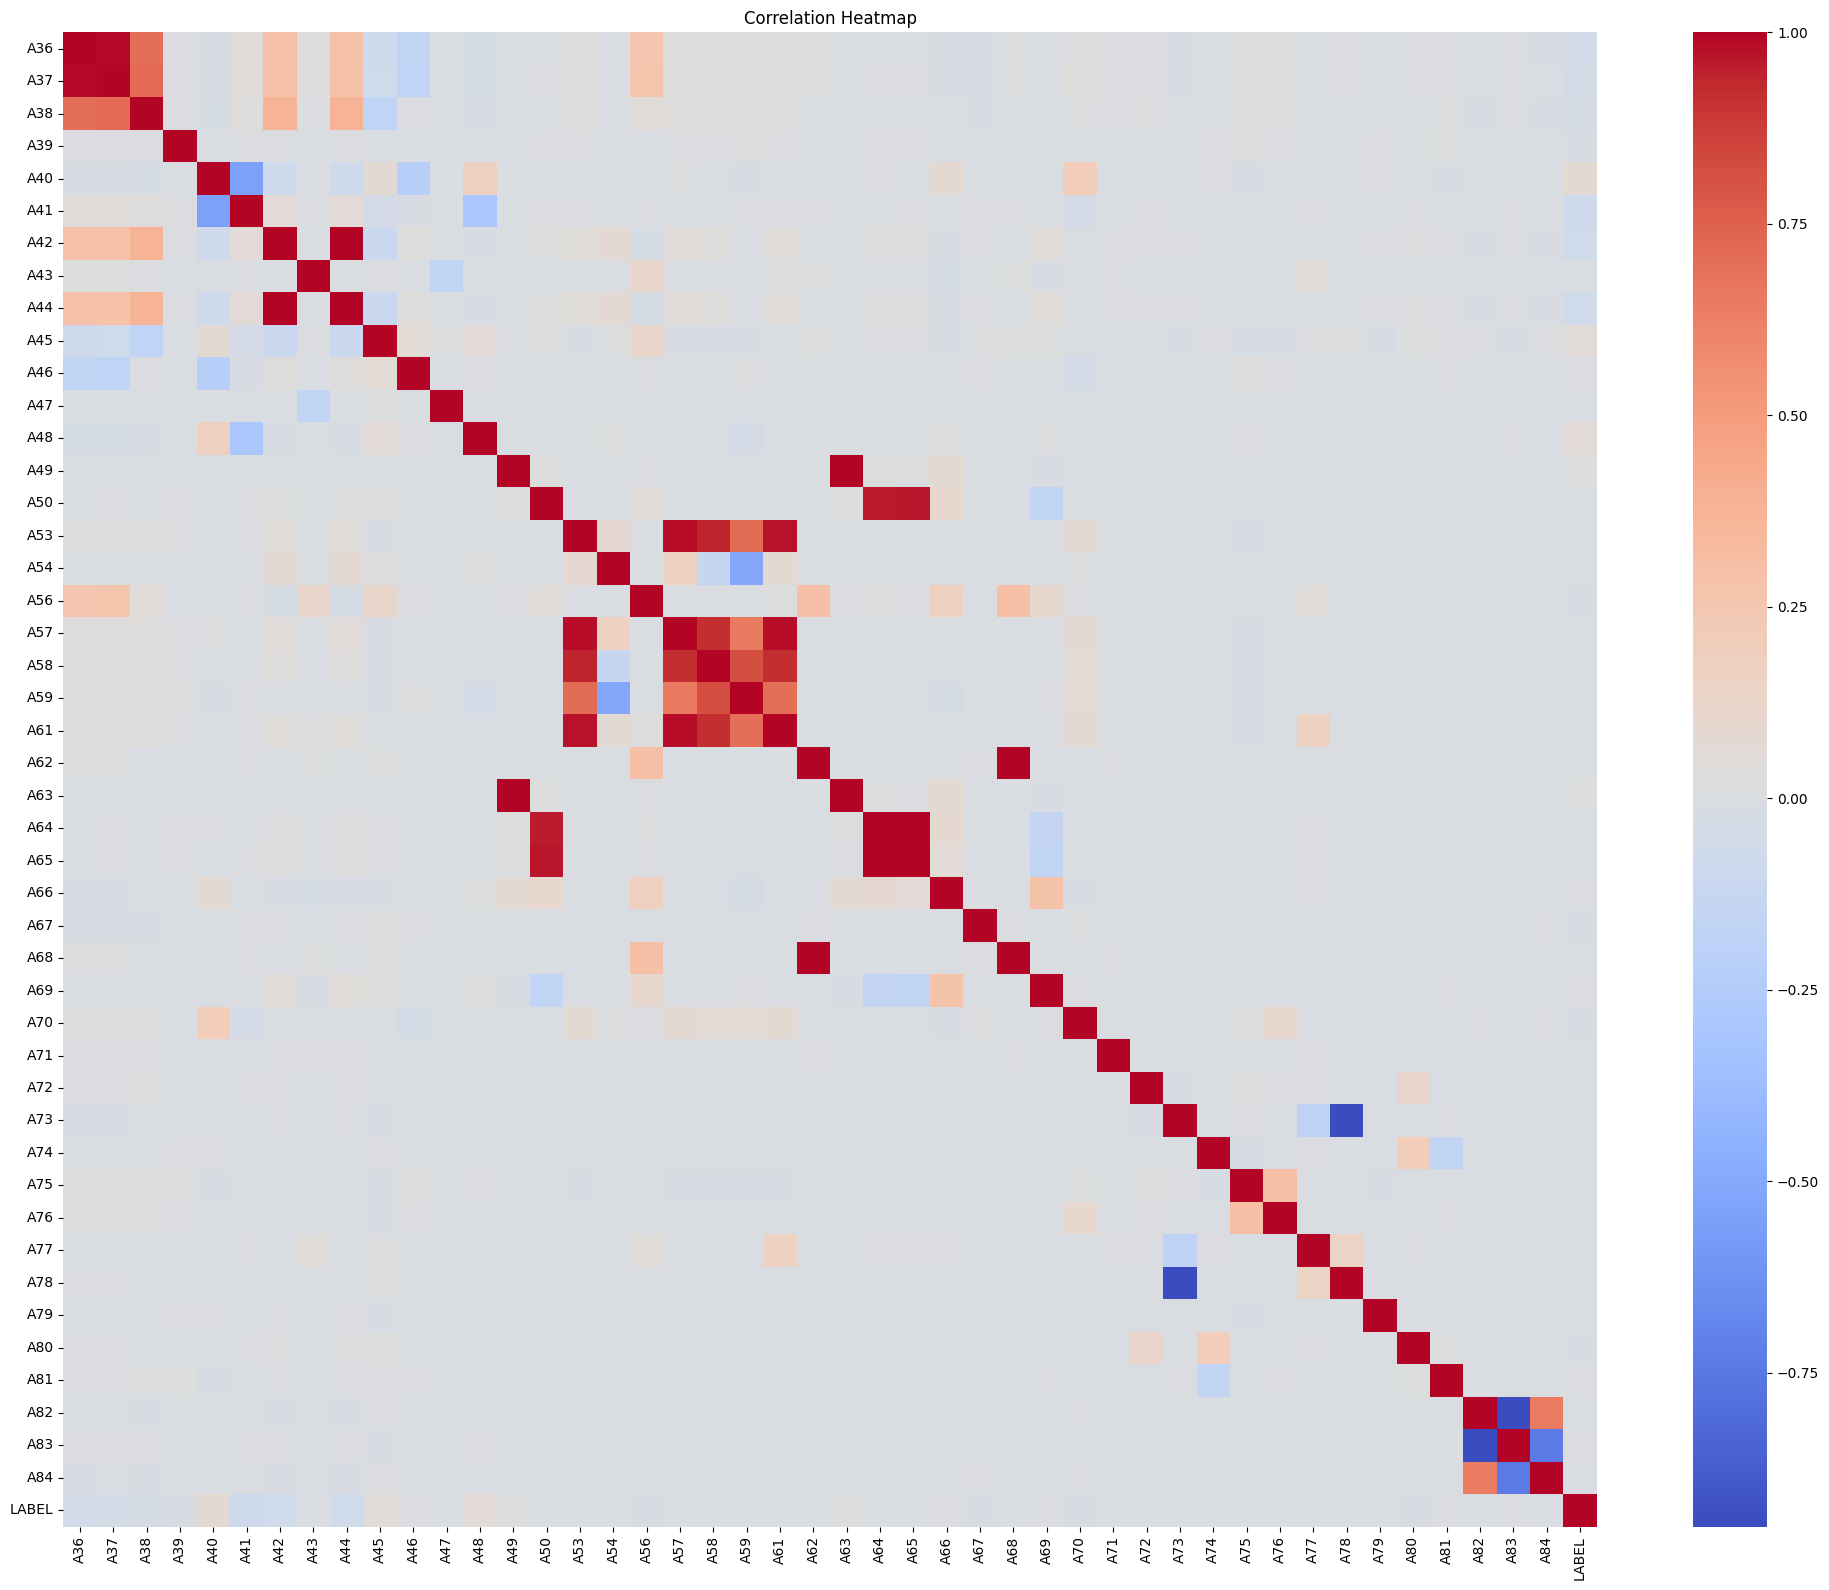


Highly correlated feature pairs:
A36 - A37: 0.99
A42 - A44: 1.00
A49 - A63: 1.00
A50 - A64: 0.96
A50 - A65: 0.97
A53 - A57: 0.98
A53 - A58: 0.94
A53 - A61: 0.97
A57 - A58: 0.92
A57 - A61: 0.98
A58 - A59: 0.82
A58 - A61: 0.92
A62 - A68: 1.00
A64 - A65: 1.00
A73 - A78: -0.94
A82 - A83: -0.95

Number of potential outliers (Isolation Forest): 1402
Number of potential outliers (Z-score > 3): 2048

Skewness of features:
A36       11.853959
A37       12.563713
A38       19.230577
A39       92.826627
A40       23.176508
A41      -44.478000
A42       15.575324
A43      -53.722598
A44       15.575324
A45        0.621959
A46      -21.737562
A47       99.696076
A48       52.564190
A49      101.725170
A50      105.927150
A53      112.645942
A54       74.679641
A56       25.852578
A57      112.588181
A58      109.329759
A59       26.478478
A61      109.457276
A62       84.054508
A63      101.707970
A64      115.887423
A65      115.988407
A66       39.638575
A67       12.941894
A68       84.154659
A

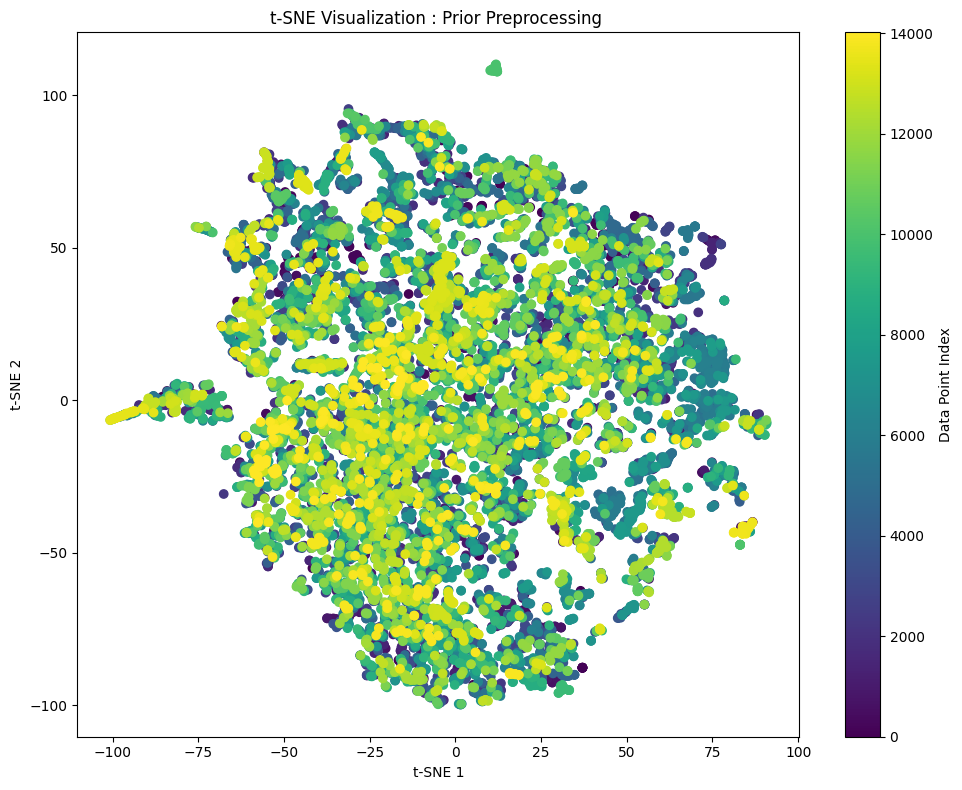

_______________________________________________________________________________
*******************************************************************************
                      Proceedings for MICE and ADASYN :
_______________________________________________________________________________
*******************************************************************************


c:\Users\dev\Desktop\MSC thesis\Code\mscthesis\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Length of labels:  14015
Time taken for impute_with_mice: 466.88 mins
 Total time taken for MICE: 467.16 mins
 ------------  TSNE after MICE processing -------------- 


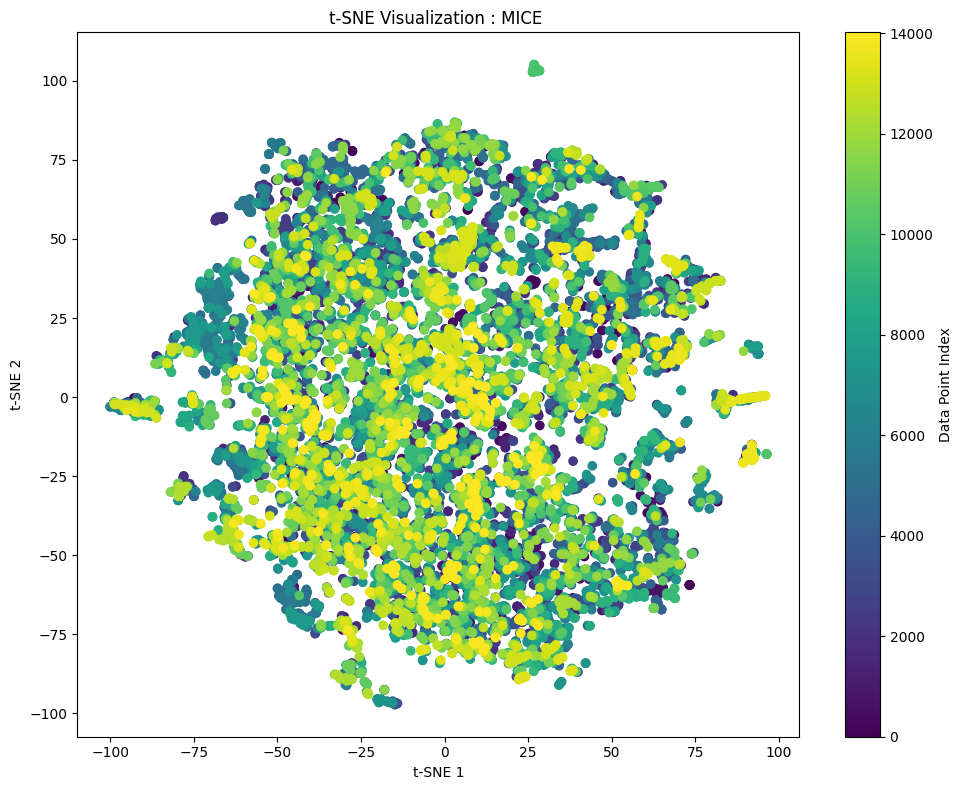

Time taken for reprocess_for_smote_pca: 0.00 mins


C:\Users\dev\AppData\Local\Temp\ipykernel_22116\4174957800.py:174: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_reprocessed["LABEL"] = df_reprocessed["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)


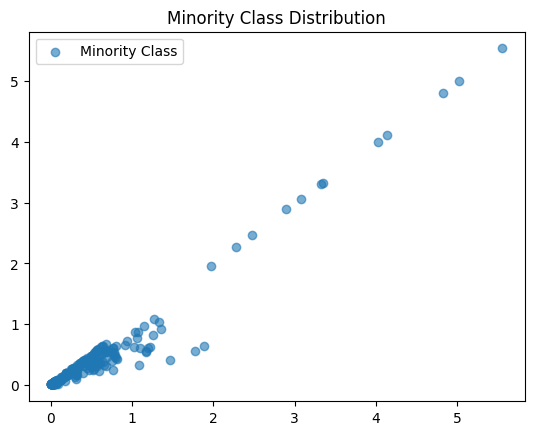

Original class distribution: Counter({0: 13708, 1: 307})
Resampled class distribution: Counter({0: 13708, 1: 13670})


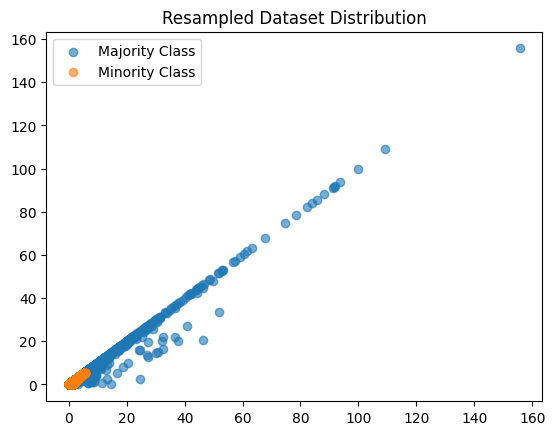

Time taken for adasyn_resampling: 0.01 mins
 Total time taken for ADASYN on MICE dataset: 0.01 mins
 ------------  TSNE after ADASYN on MICE dataset processing -------------- 


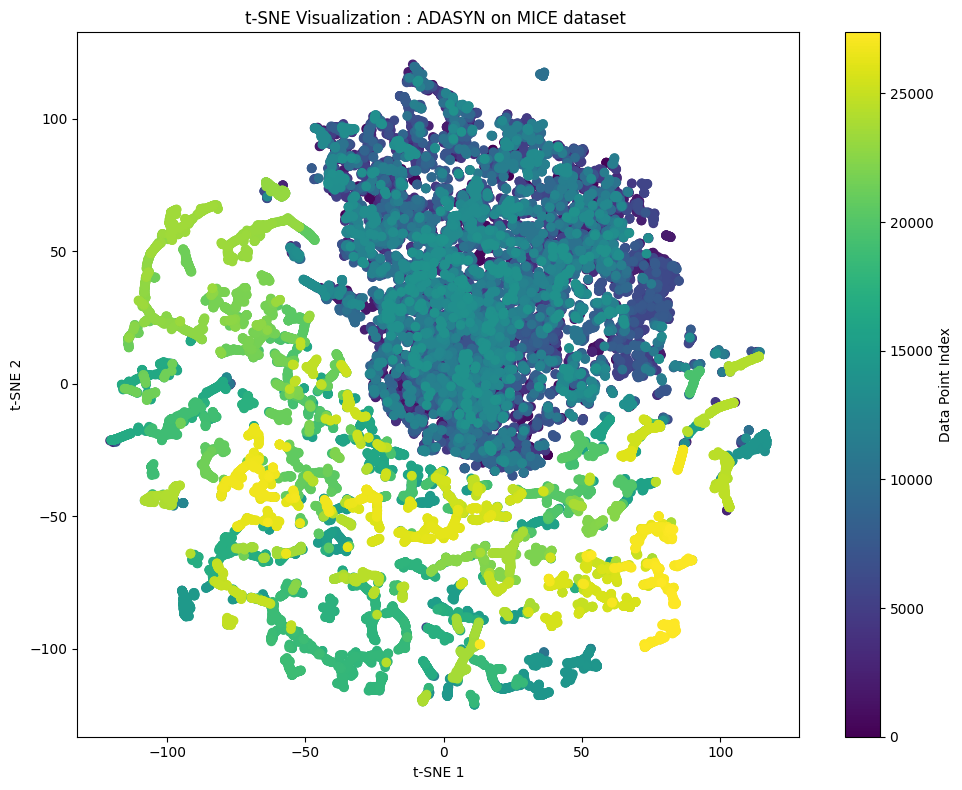

   Liquidity_and_Coverage_Ratios_PC1  Liquidity_and_Coverage_Ratios_PC2  \
0                           0.849647                           0.377224   
1                           1.357241                           0.324384   
2                           0.605441                           0.443139   

   Leverage_Ratios_PC1  Leverage_Ratios_PC2  Activity_Ratios_PC1  \
0            -0.478812             0.123778            -1.084980   
1            -0.521284             0.144872            -1.074990   
2            -0.505793             0.138354            -1.071052   

   Activity_Ratios_PC2  Profitability_Ratios_PC1  Profitability_Ratios_PC2  \
0             0.004294                 -0.012109                 -0.022919   
1             0.003597                 -0.014365                 -0.021802   
2             0.003358                 -0.012419                 -0.021788   

   Cost_and_Expense_Ratios_PC1  Cost_and_Expense_Ratios_PC2  \
0                    -0.029924                    

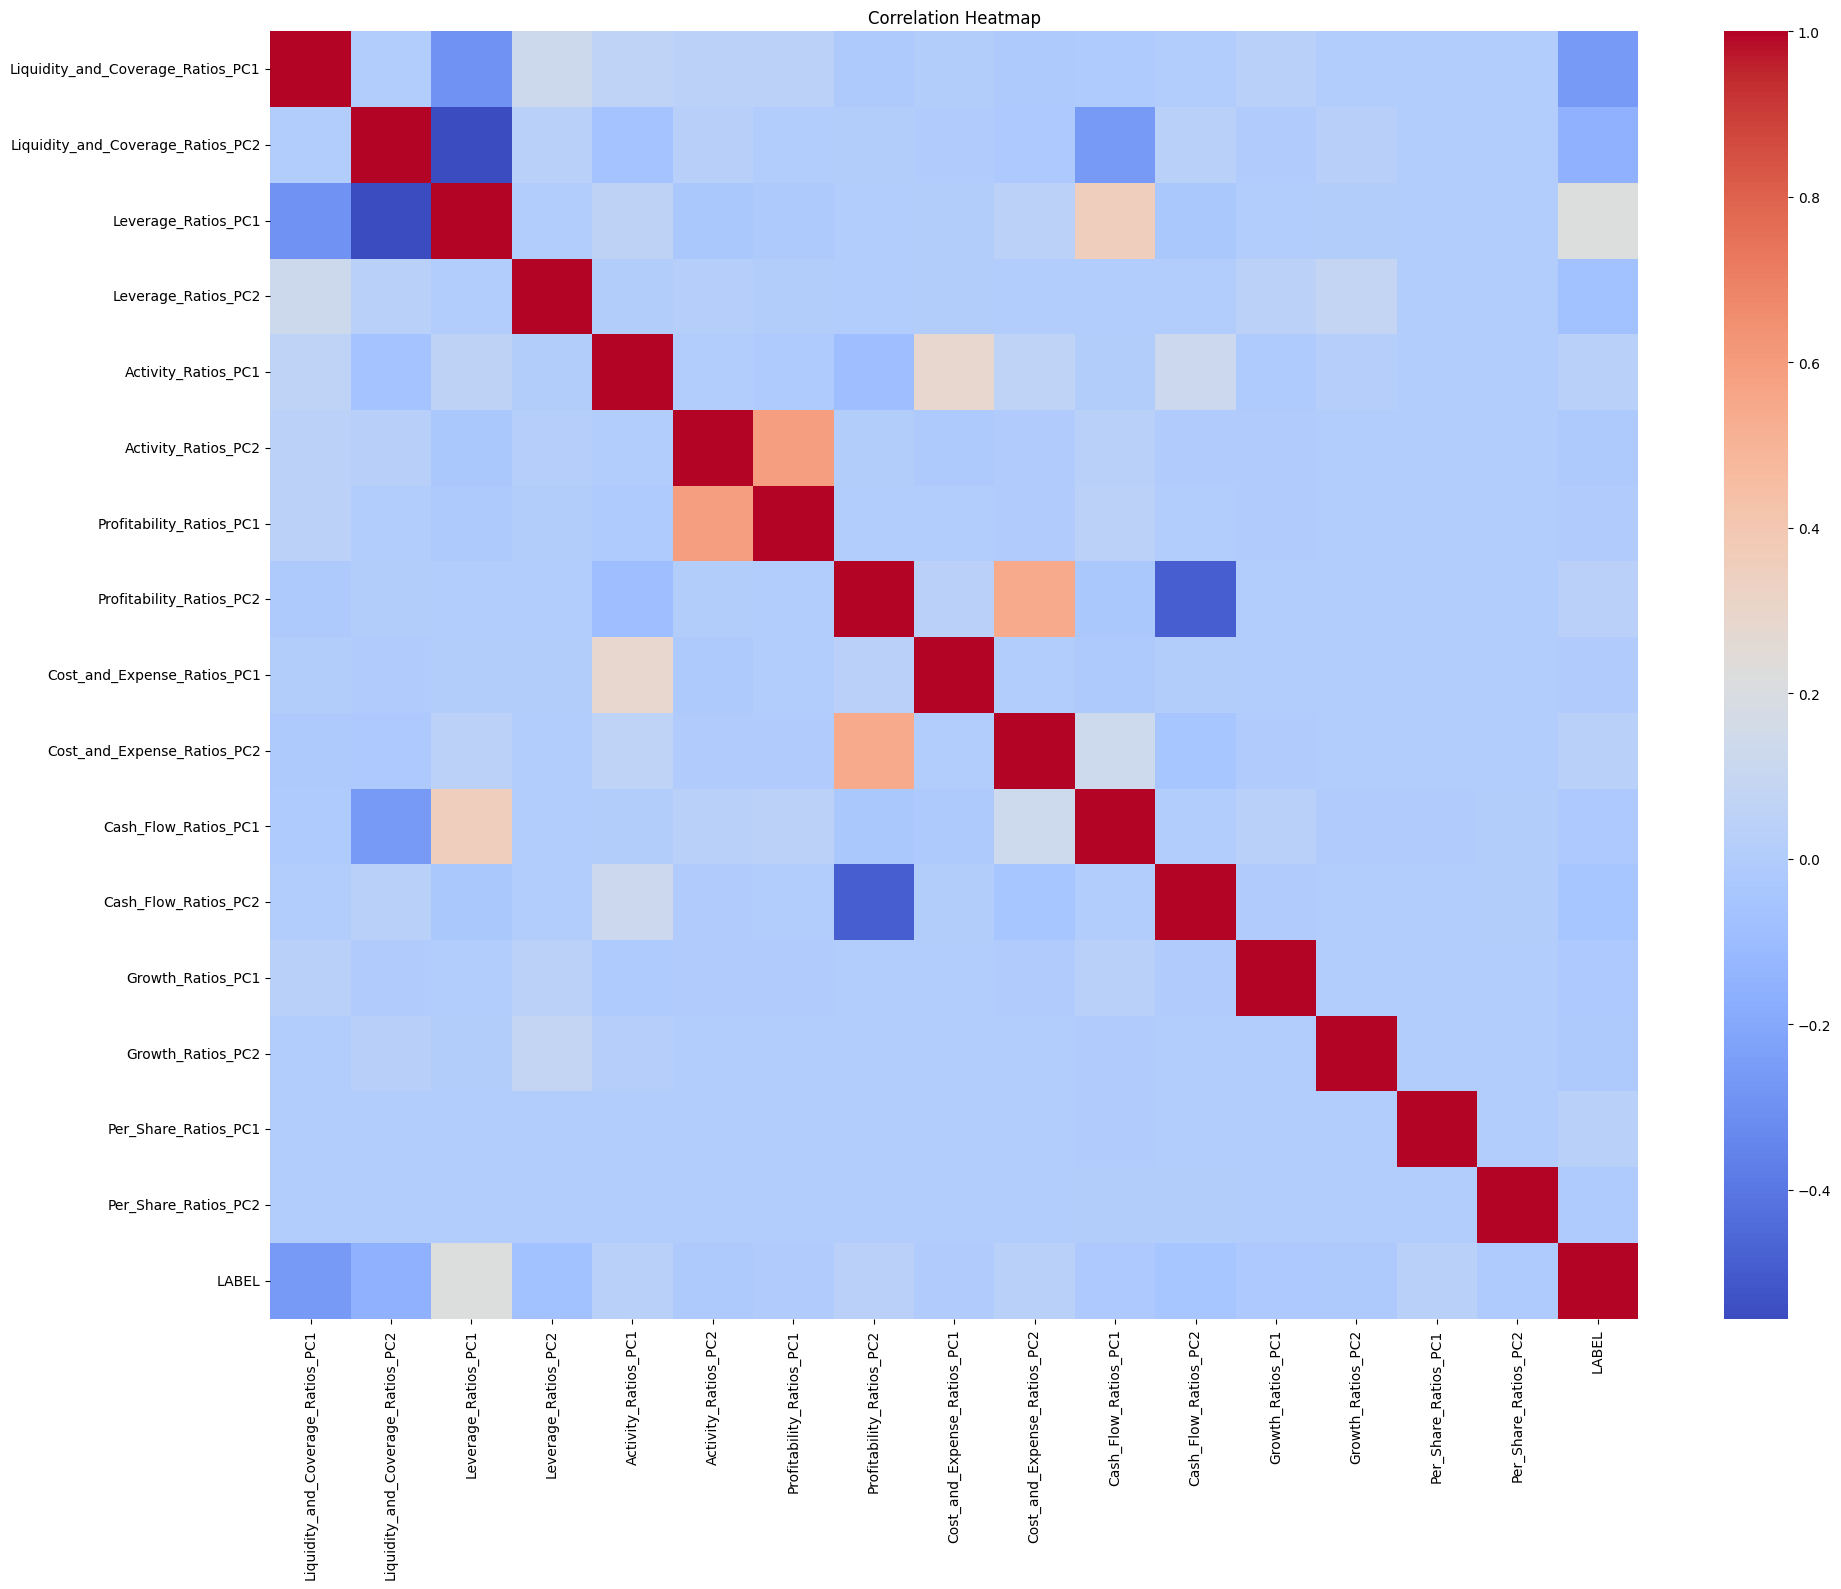


Highly correlated feature pairs:

Number of potential outliers (Isolation Forest): 2738
Number of potential outliers (Z-score > 3): 2245

Skewness of features:
Liquidity_and_Coverage_Ratios_PC1     17.963011
Liquidity_and_Coverage_Ratios_PC2    -24.052255
Leverage_Ratios_PC1                   15.421426
Leverage_Ratios_PC2                   39.021694
Activity_Ratios_PC1                   13.416199
Activity_Ratios_PC2                   89.643642
Profitability_Ratios_PC1             157.924264
Profitability_Ratios_PC2             -28.992727
Cost_and_Expense_Ratios_PC1          156.486157
Cost_and_Expense_Ratios_PC2           28.678980
Cash_Flow_Ratios_PC1                  15.024395
Cash_Flow_Ratios_PC2                  42.410749
Growth_Ratios_PC1                     63.908841
Growth_Ratios_PC2                     84.990796
Per_Share_Ratios_PC1                 -53.318457
Per_Share_Ratios_PC2                  11.559038
LABEL                                  0.002776
dtype: float64

Kurtosi

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 45)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 22)             │         1,012 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 45)             │         1,035 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,047 (8.00 KB)

 Trainable params: 2,047 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step - loss: 1.4763 - val_loss: 0.8604
Epoch 2/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 0.9212 - val_loss: 0.7493
Epoch 3/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 1.1355 - val_loss: 0.6926
Epoch 4/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 0.8332 - val_loss: 0.6535
Epoch 5/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 0.9709 - val_loss: 0.6277
Epoch 6/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 0.6585 - val_loss: 0.6116
Epoch 7/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 0.5422 - val_loss: 0.6026
Epoch 8/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 0.5177 - val_loss: 0.5883
Epoch 9/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.4616 - val_loss: 0.5828
Epoch 10/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 0.6244 - val_loss: 0.5770
Epoch 11/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 0.4515 - val_loss: 0.5656
Epoch 12/35
351/351 ━━━━━━━━━━

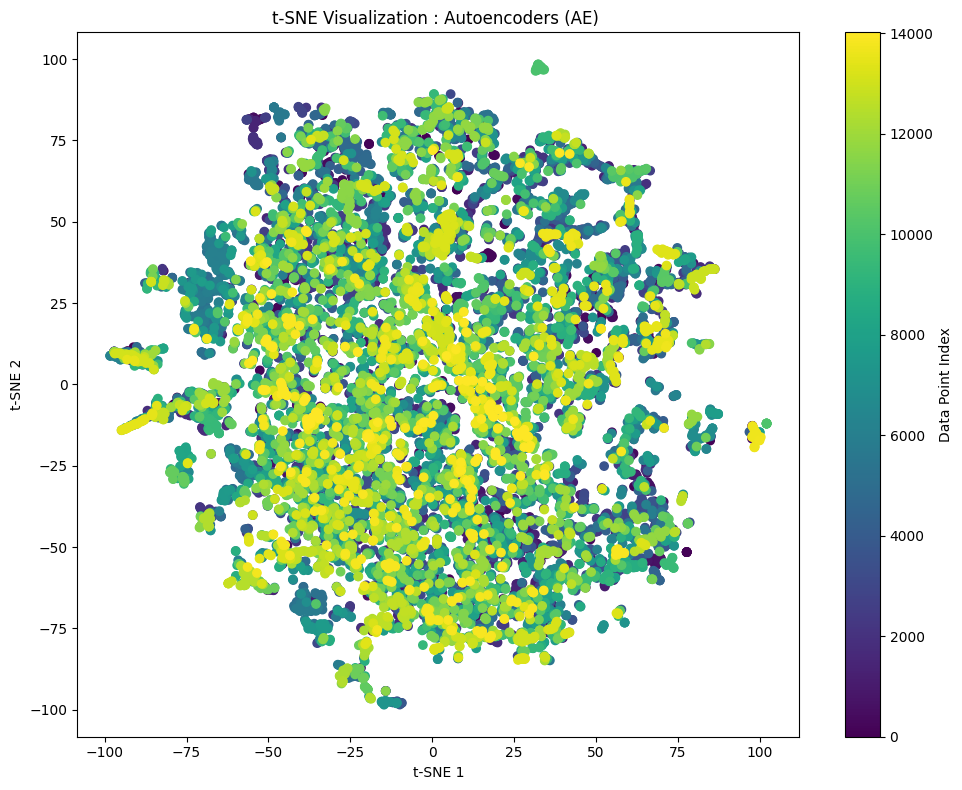

Time taken for reprocess_for_smote_pca: 0.00 mins


C:\Users\dev\AppData\Local\Temp\ipykernel_22116\4174957800.py:174: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_reprocessed["LABEL"] = df_reprocessed["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)


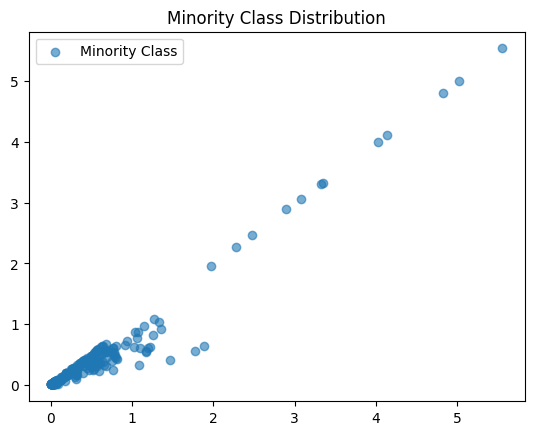

Original class distribution: Counter({0: 13708, 1: 307})
Resampled class distribution: Counter({0: 13708, 1: 13701})


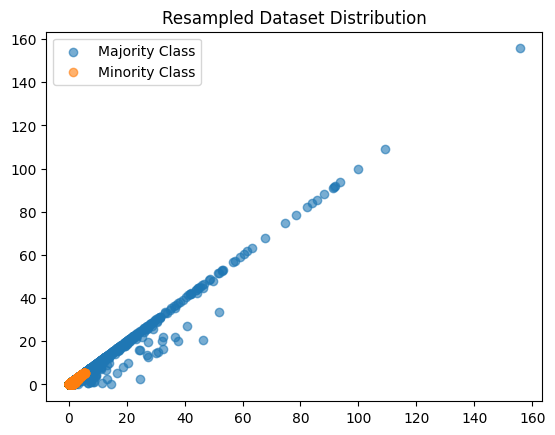

Time taken for adasyn_resampling: 0.01 mins
 Total time taken for ADASYN on Autoencoders dataset: 0.01 mins
 ------------  TSNE after Autoencoder (AE) and ADASYN processing -------------- 


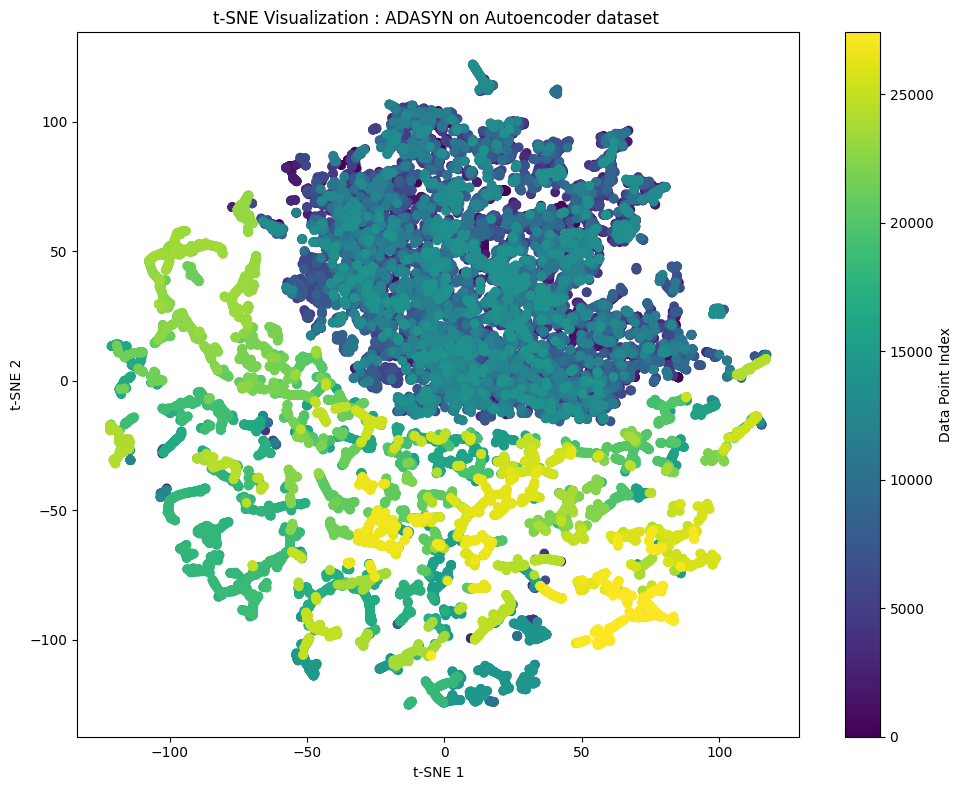

   Liquidity_and_Coverage_Ratios_PC1  Liquidity_and_Coverage_Ratios_PC2  \
0                           0.850835                           0.370822   
1                           1.358038                           0.318343   
2                           0.607177                           0.433754   

   Leverage_Ratios_PC1  Leverage_Ratios_PC2  Activity_Ratios_PC1  \
0            -0.477106            -0.023239            -0.775934   
1            -0.520056            -0.025719            -0.769587   
2            -0.504433            -0.022612            -0.766550   

   Activity_Ratios_PC2  Profitability_Ratios_PC1  Profitability_Ratios_PC2  \
0             0.221493                 -0.011856                 -0.021469   
1             0.214068                 -0.014114                 -0.020322   
2             0.213273                 -0.012166                 -0.020307   

   Cost_and_Expense_Ratios_PC1  Cost_and_Expense_Ratios_PC2  \
0                    -0.026866                    

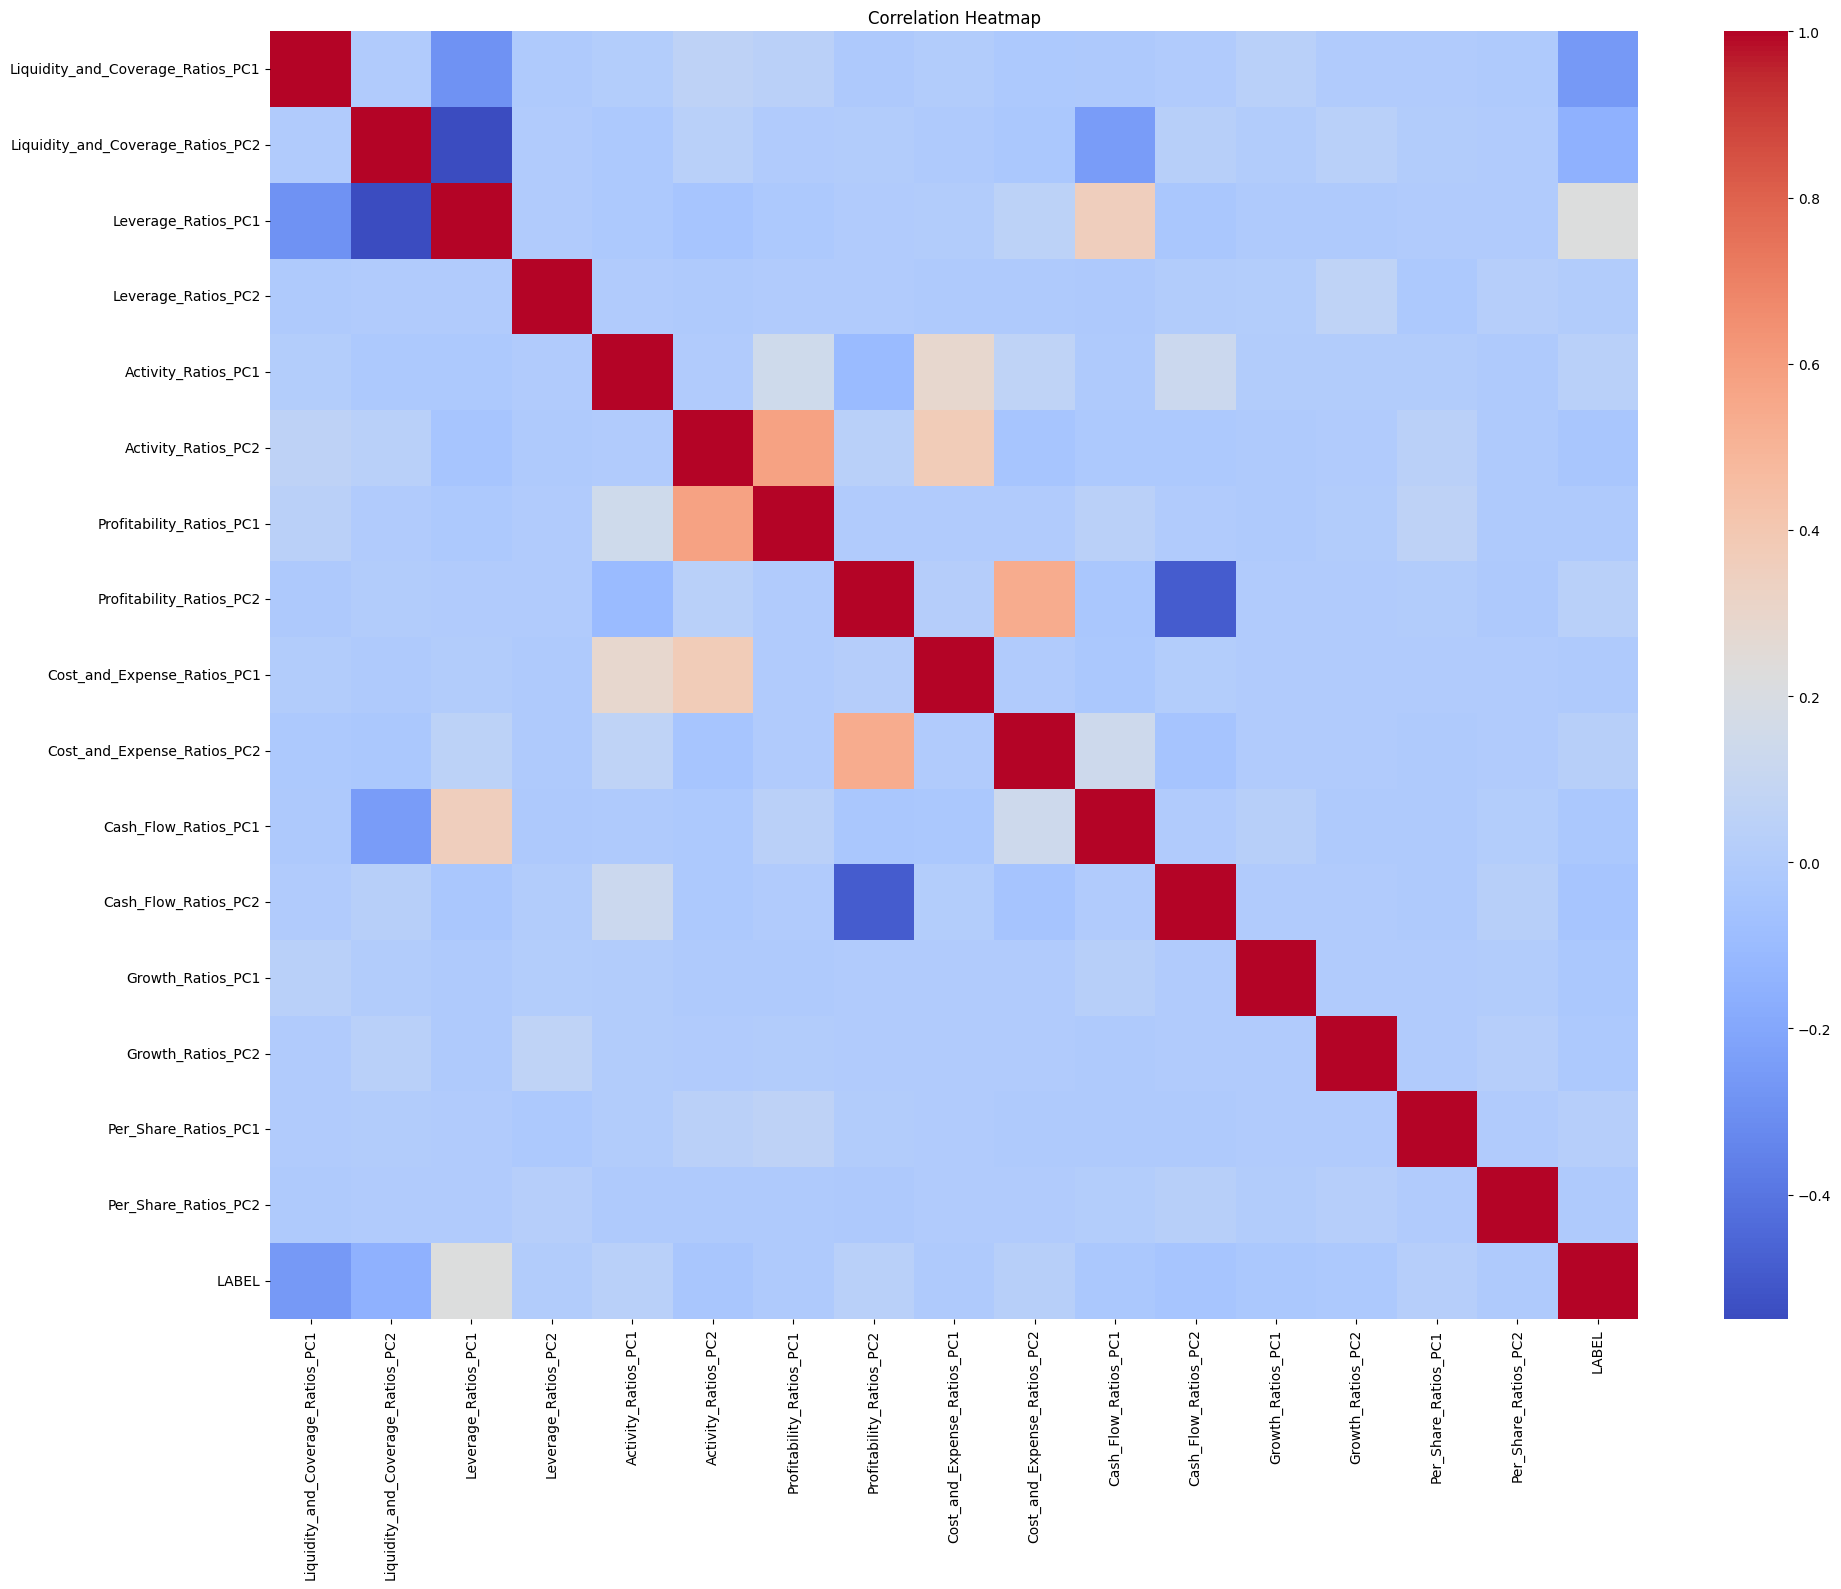


Highly correlated feature pairs:

Number of potential outliers (Isolation Forest): 2741
Number of potential outliers (Z-score > 3): 2233

Skewness of features:
Liquidity_and_Coverage_Ratios_PC1     17.930720
Liquidity_and_Coverage_Ratios_PC2    -23.052736
Leverage_Ratios_PC1                   15.741259
Leverage_Ratios_PC2                   44.546319
Activity_Ratios_PC1                    8.597187
Activity_Ratios_PC2                   73.120803
Profitability_Ratios_PC1             158.013065
Profitability_Ratios_PC2             -28.301640
Cost_and_Expense_Ratios_PC1          157.280893
Cost_and_Expense_Ratios_PC2           29.862545
Cash_Flow_Ratios_PC1                  15.283433
Cash_Flow_Ratios_PC2                  42.873286
Growth_Ratios_PC1                     63.554446
Growth_Ratios_PC2                     84.138031
Per_Share_Ratios_PC1                 -52.877558
Per_Share_Ratios_PC2                  11.506089
LABEL                                  0.000511
dtype: float64

Kurtosi

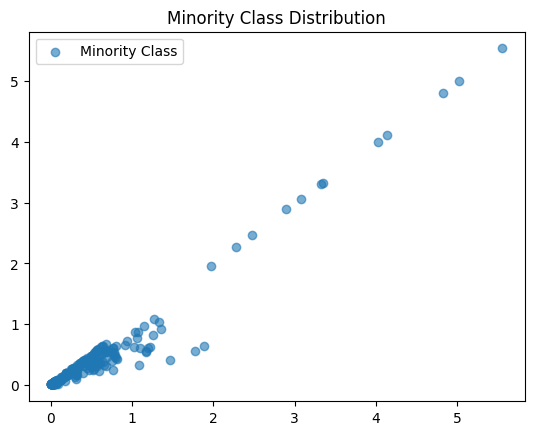

Original class distribution: Counter({0: 13708, 1: 307})
Resampled class distribution: Counter({1: 13709, 0: 13708})


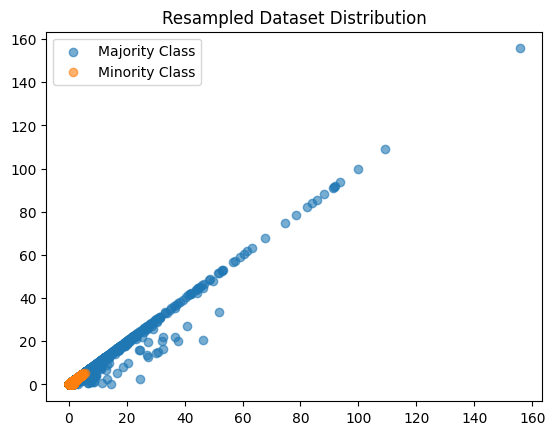

Time taken for kmeans_smote_resampling: 0.01 mins
 Total time taken for KmeansSMOTE on MICE dataset: 0.01 mins
   Liquidity_and_Coverage_Ratios_PC1  Liquidity_and_Coverage_Ratios_PC2  \
0                           0.915845                           0.480542   
1                           1.421382                           0.406534   
2                           0.673423                           0.564225   

   Leverage_Ratios_PC1  Leverage_Ratios_PC2  Activity_Ratios_PC1  \
0            -0.650304             0.011610            -1.139155   
1            -0.699194             0.015938            -1.129182   
2            -0.681876             0.015951            -1.125252   

   Activity_Ratios_PC2  Profitability_Ratios_PC1  Profitability_Ratios_PC2  \
0            -0.024651                 -0.009483                 -0.017061   
1            -0.025088                 -0.011740                 -0.015809   
2            -0.025225                 -0.009793                 -0.015792   

  

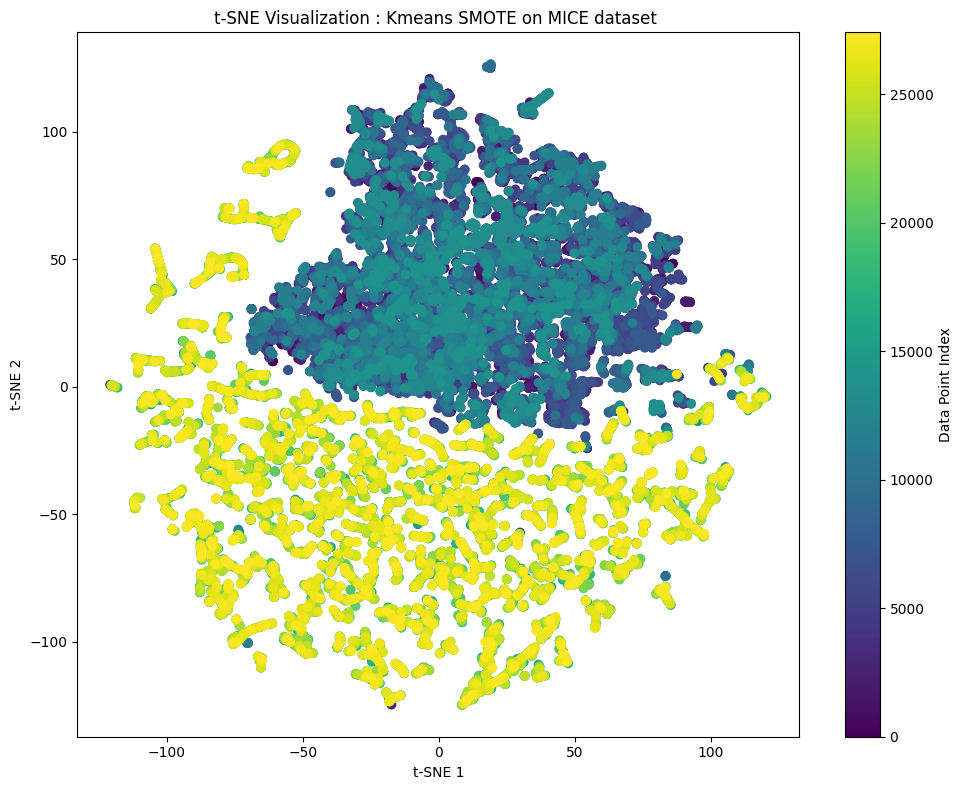

Comprehensive analysis on MICE processed dataset with KMeans SMOTE:
Basic Statistics:
       Liquidity_and_Coverage_Ratios_PC1  Liquidity_and_Coverage_Ratios_PC2  \
count                       27417.000000                       2.741700e+04   
mean                            0.000000                       4.146582e-18   
std                             1.693385                       1.007483e+00   
min                            -8.596986                      -5.740614e+01   
25%                            -0.536430                      -1.786298e-01   
50%                            -0.309160                       1.888350e-01   
75%                             0.078248                       3.433802e-01   
max                           105.751159                       2.797875e+01   

       Leverage_Ratios_PC1  Leverage_Ratios_PC2  Activity_Ratios_PC1  \
count         2.741700e+04         2.741700e+04         2.741700e+04   
mean          1.658633e-17        -5.183227e-19        -3.

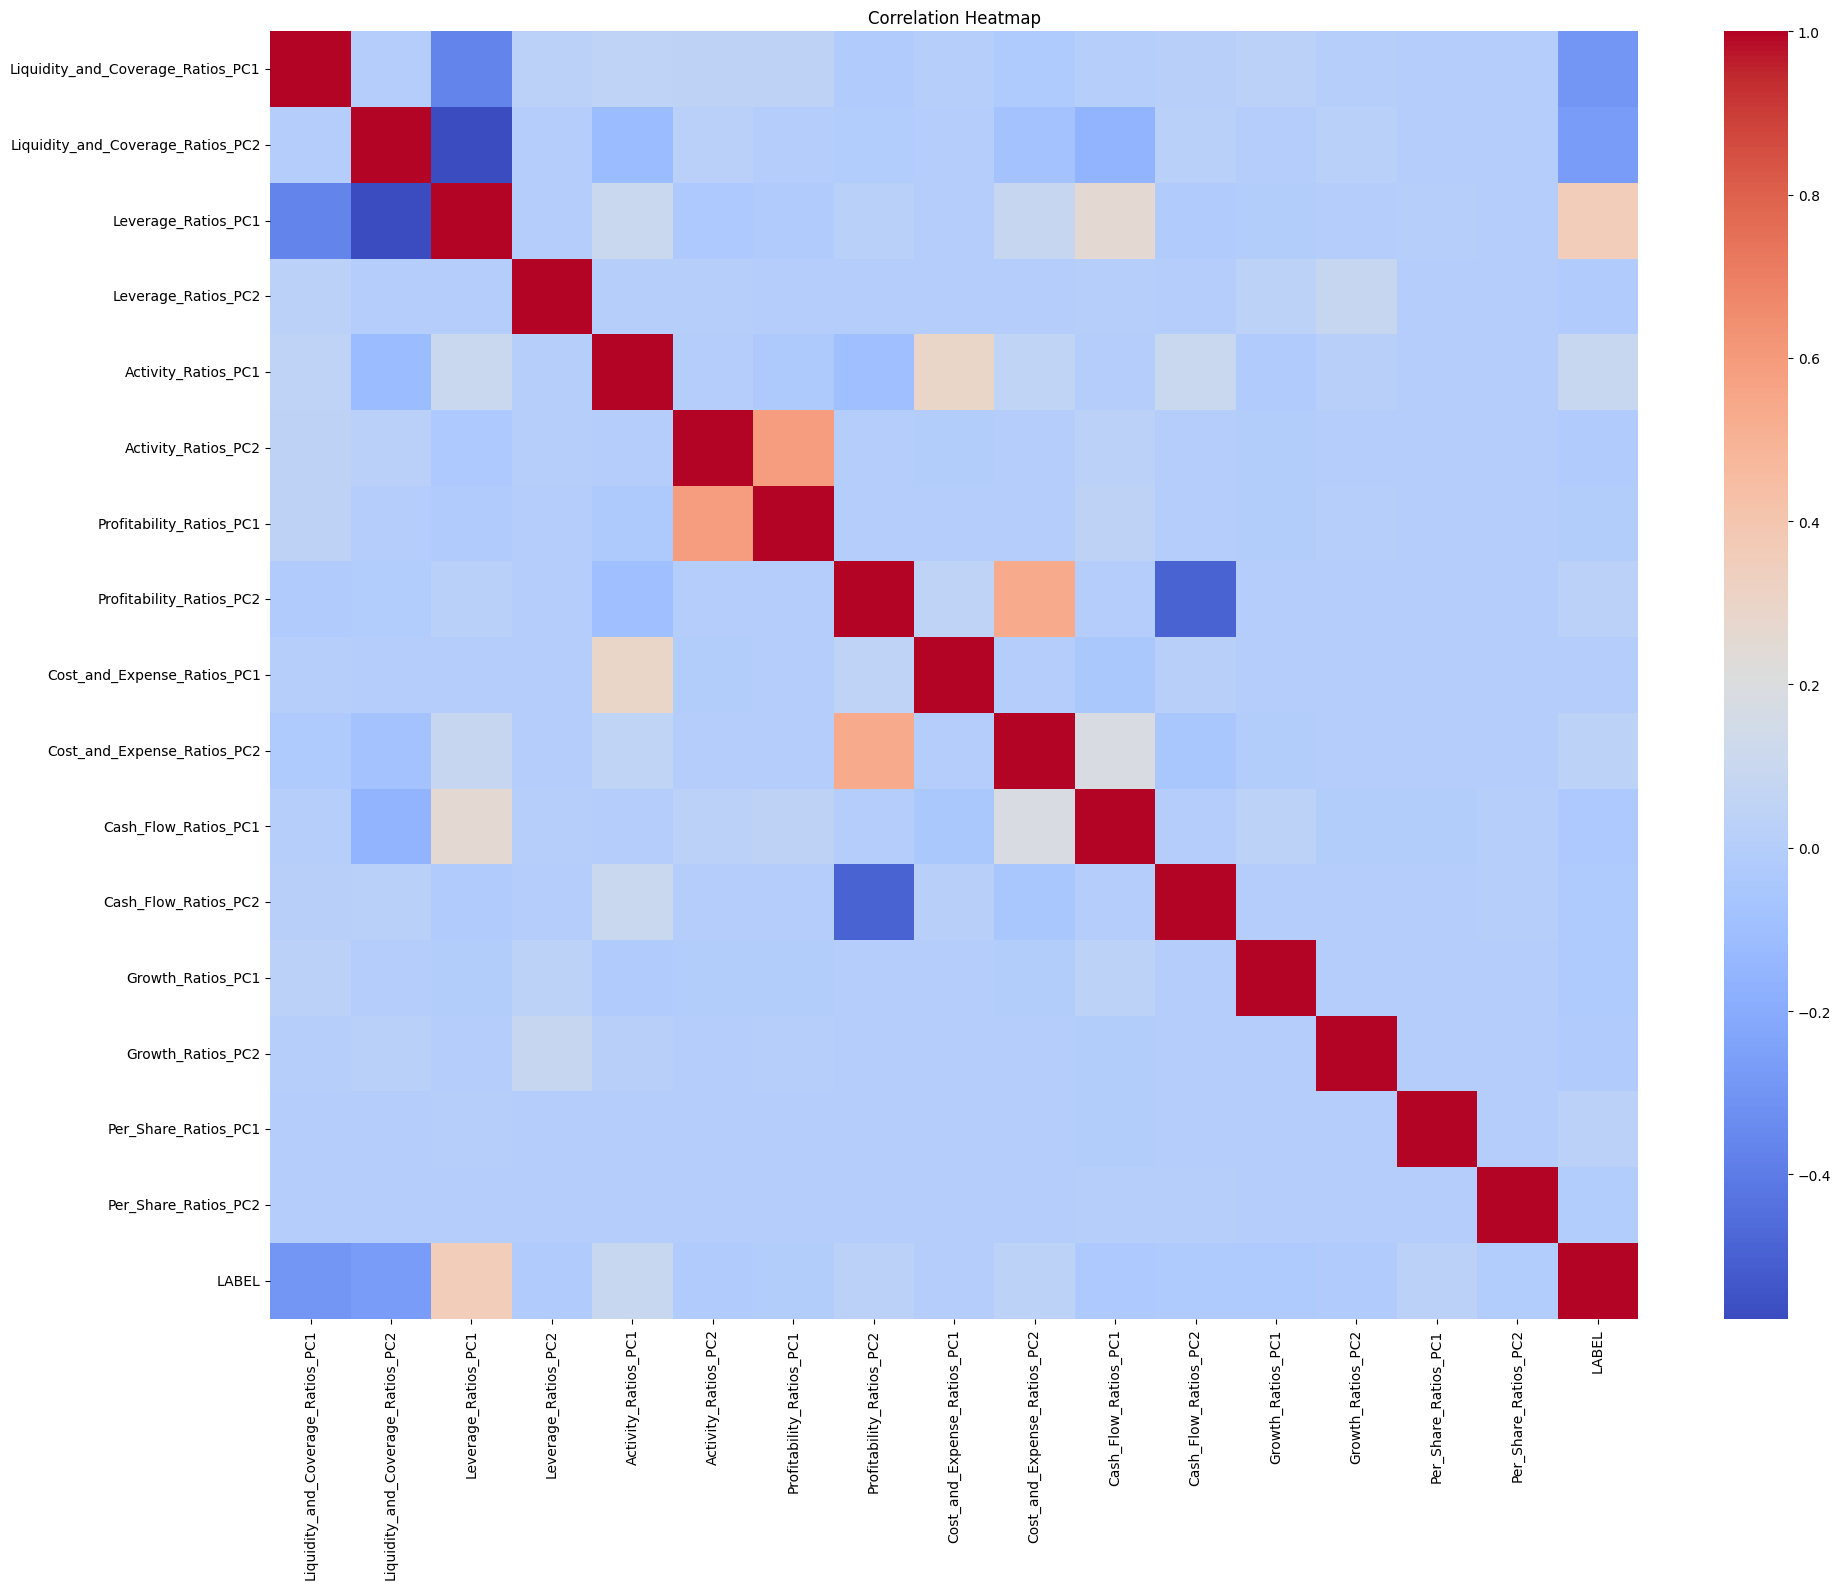


Highly correlated feature pairs:

Number of potential outliers (Isolation Forest): 2742
Number of potential outliers (Z-score > 3): 1945

Skewness of features:
Liquidity_and_Coverage_Ratios_PC1     17.616275
Liquidity_and_Coverage_Ratios_PC2    -17.631927
Leverage_Ratios_PC1                    9.776329
Leverage_Ratios_PC2                   57.765415
Activity_Ratios_PC1                   13.707391
Activity_Ratios_PC2                   89.753702
Profitability_Ratios_PC1             158.047552
Profitability_Ratios_PC2             -25.490882
Cost_and_Expense_Ratios_PC1          156.966711
Cost_and_Expense_Ratios_PC2           29.818506
Cash_Flow_Ratios_PC1                  18.847438
Cash_Flow_Ratios_PC2                  44.043920
Growth_Ratios_PC1                     63.959746
Growth_Ratios_PC2                     85.665724
Per_Share_Ratios_PC1                 -53.351041
Per_Share_Ratios_PC2                  11.563916
LABEL                                 -0.000073
dtype: float64

Kurtosi

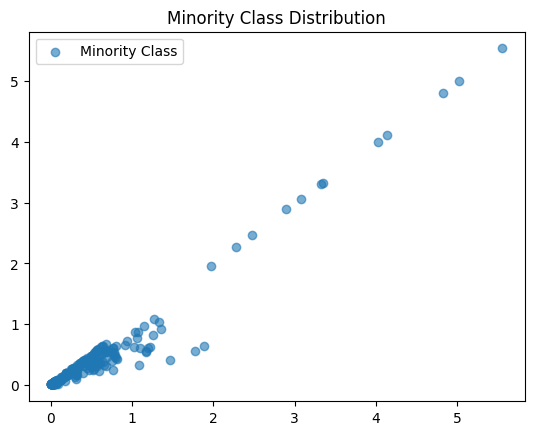

Original class distribution: Counter({0: 13708, 1: 307})
Resampled class distribution: Counter({1: 13709, 0: 13708})


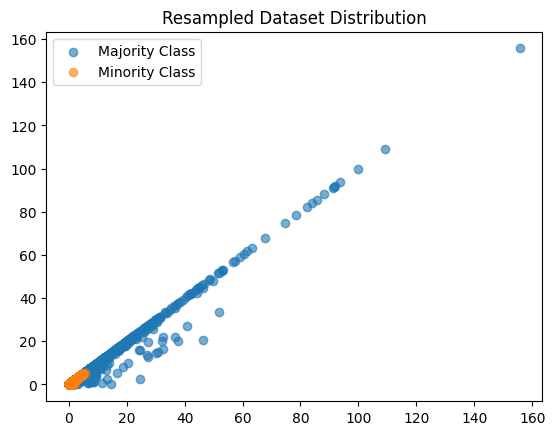

Time taken for kmeans_smote_resampling: 0.01 mins
 Total time taken for KmeansSMOTE on Autoencoder dataset: 0.01 mins
   Liquidity_and_Coverage_Ratios_PC1  Liquidity_and_Coverage_Ratios_PC2  \
0                           0.917701                           0.475810   
1                           1.422491                           0.401459   
2                           0.676001                           0.556590   

   Leverage_Ratios_PC1  Leverage_Ratios_PC2  Activity_Ratios_PC1  \
0            -0.651967            -0.002795            -0.792425   
1            -0.700875            -0.001337            -0.786401   
2            -0.683566             0.000053            -0.783491   

   Activity_Ratios_PC2  Profitability_Ratios_PC1  Profitability_Ratios_PC2  \
0             0.248753                 -0.009463                 -0.017068   
1             0.241229                 -0.011720                 -0.015816   
2             0.240394                 -0.009772                 -0.015799

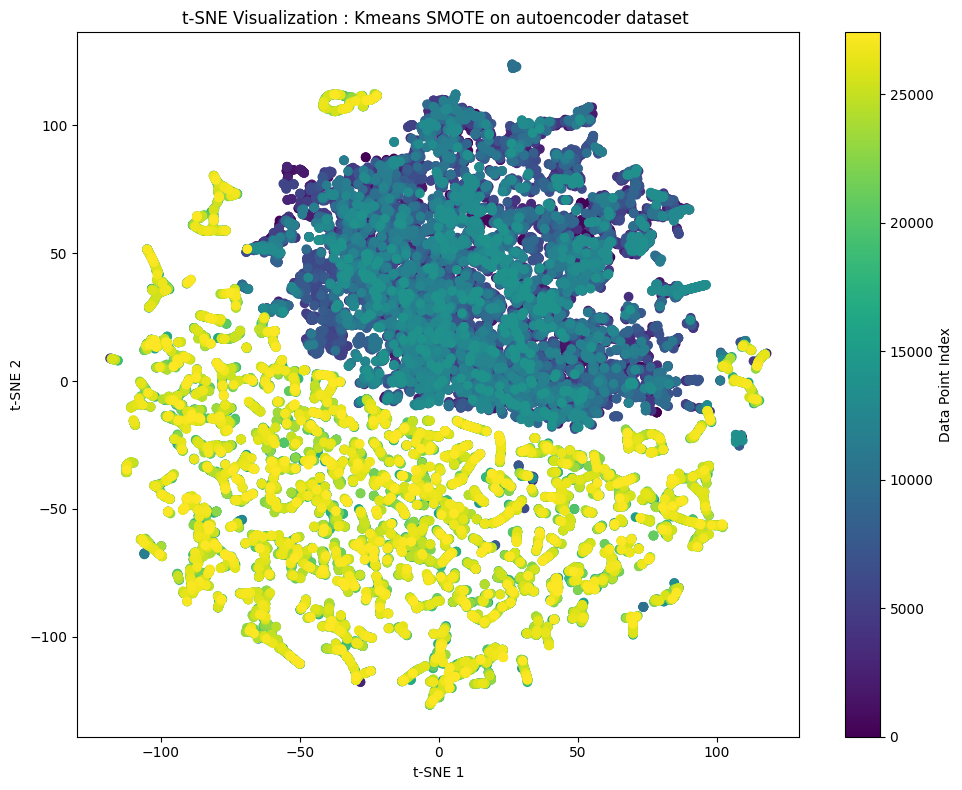

Comprehensive analysis on Autoencoder processed dataset with KMeans SMOTE:
Basic Statistics:
       Liquidity_and_Coverage_Ratios_PC1  Liquidity_and_Coverage_Ratios_PC2  \
count                       2.741700e+04                       2.741700e+04   
mean                        1.658633e-17                       4.146582e-18   
std                         1.694560e+00                       1.006806e+00   
min                        -8.607099e+00                      -5.697259e+01   
25%                        -5.381886e-01                      -1.778364e-01   
50%                        -3.084209e-01                       1.891959e-01   
75%                         7.987729e-02                       3.419715e-01   
max                         1.057558e+02                       3.131433e+01   

       Leverage_Ratios_PC1  Leverage_Ratios_PC2  Activity_Ratios_PC1  \
count         2.741700e+04         2.741700e+04         2.741700e+04   
mean          1.658633e-17         7.774841e-19    

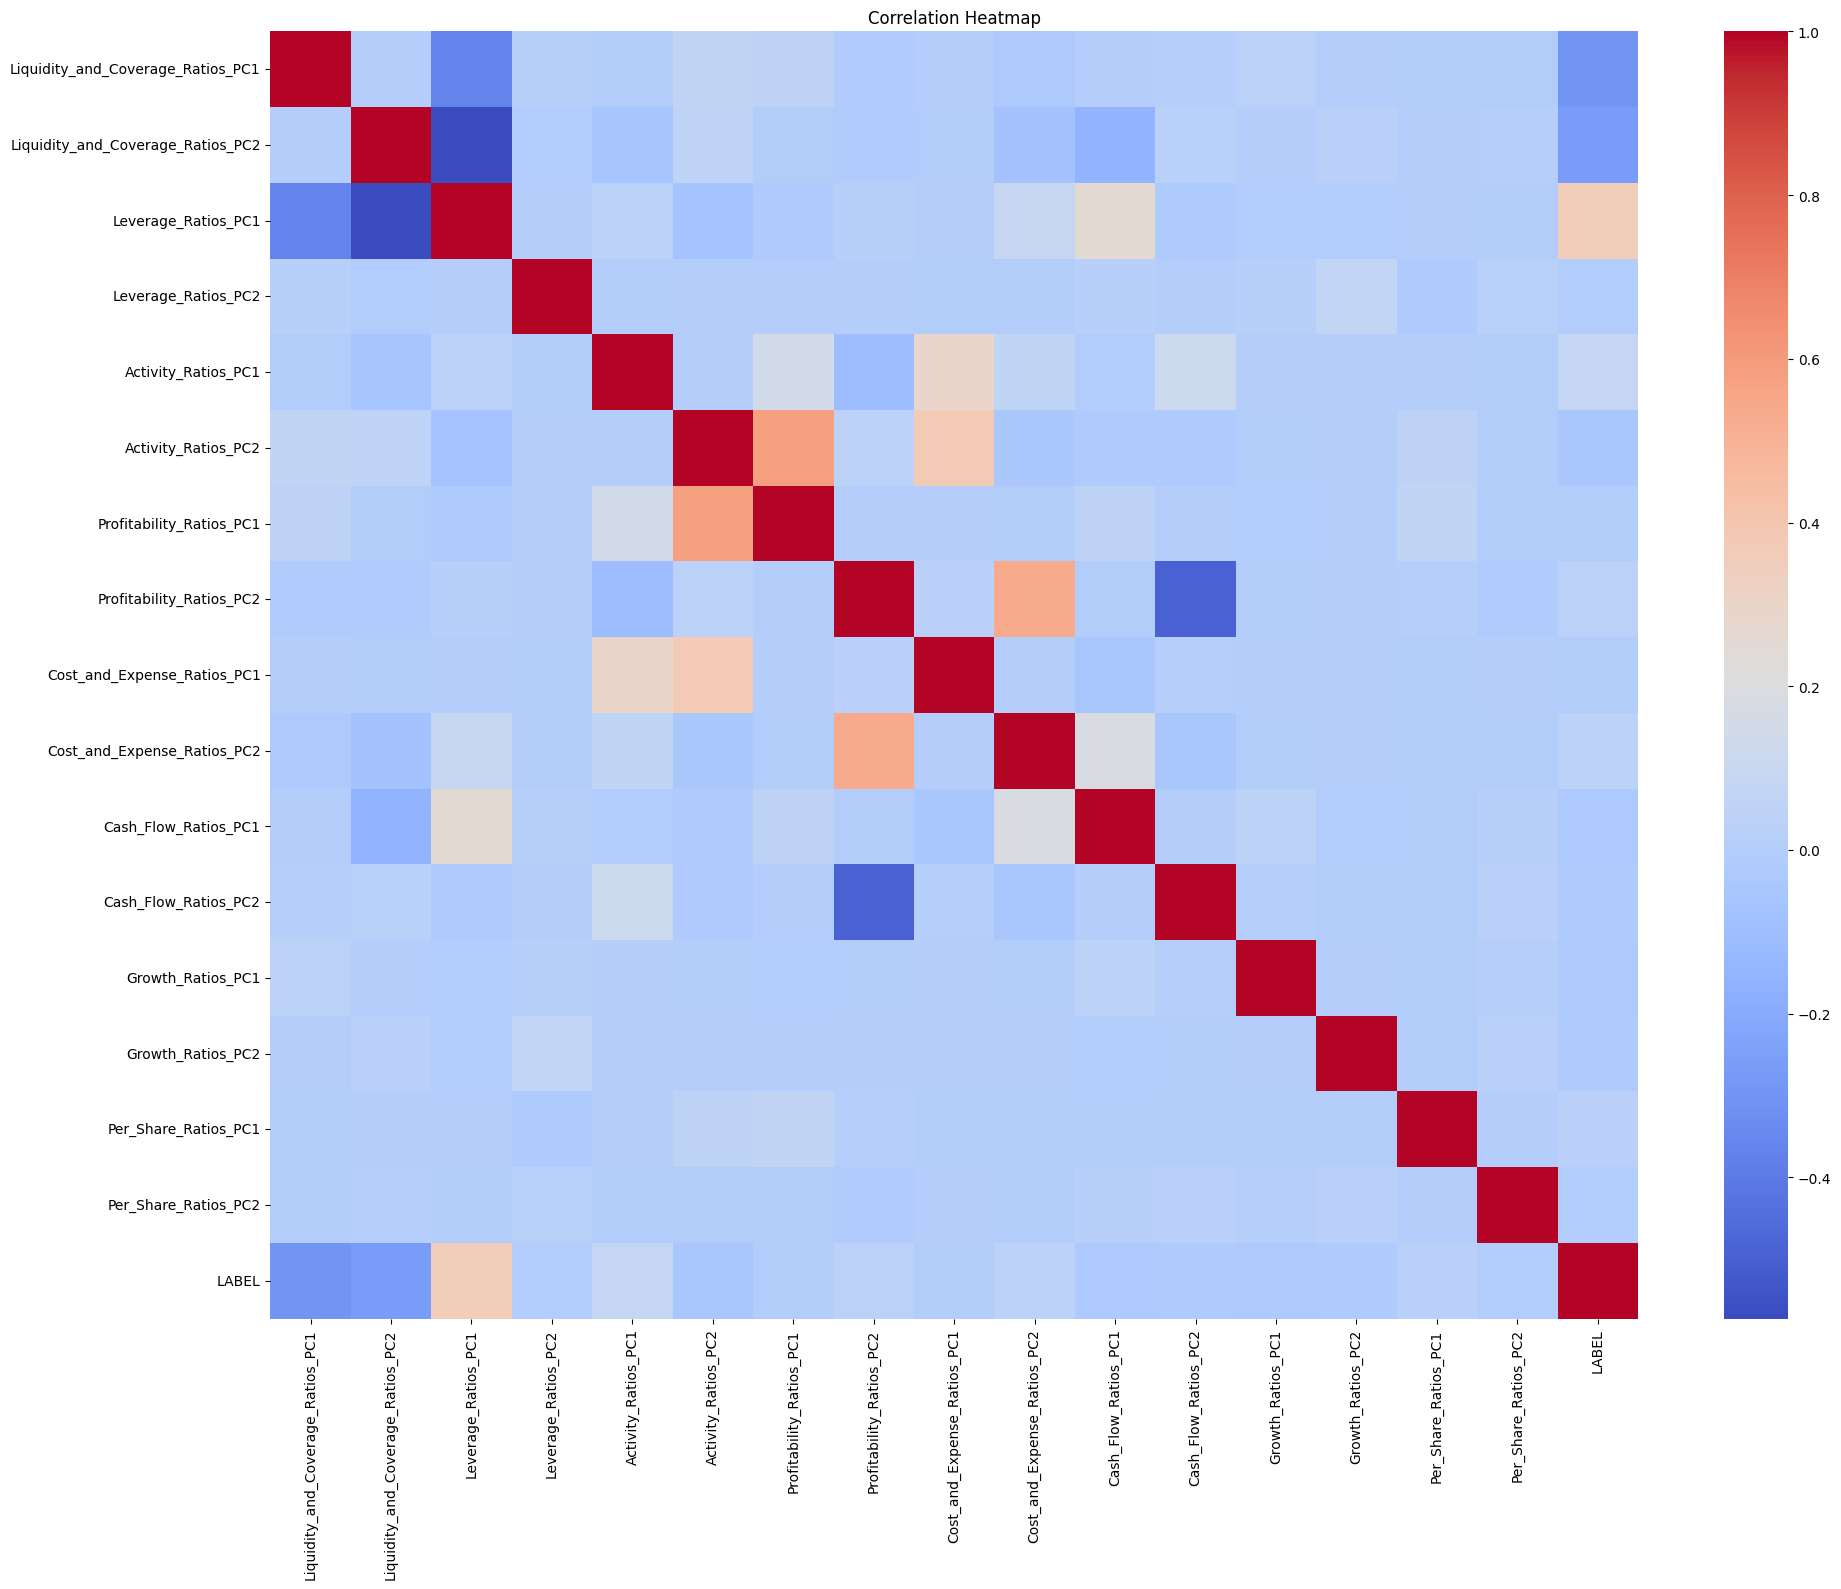


Highly correlated feature pairs:

Number of potential outliers (Isolation Forest): 2738
Number of potential outliers (Z-score > 3): 2000

Skewness of features:
Liquidity_and_Coverage_Ratios_PC1     17.560331
Liquidity_and_Coverage_Ratios_PC2    -16.998787
Leverage_Ratios_PC1                    9.664641
Leverage_Ratios_PC2                   58.172213
Activity_Ratios_PC1                    8.121784
Activity_Ratios_PC2                   73.082081
Profitability_Ratios_PC1             158.047492
Profitability_Ratios_PC2             -25.486226
Cost_and_Expense_Ratios_PC1          157.832543
Cost_and_Expense_Ratios_PC2           30.284920
Cash_Flow_Ratios_PC1                  18.834861
Cash_Flow_Ratios_PC2                  43.894344
Growth_Ratios_PC1                     63.665851
Growth_Ratios_PC2                     84.216363
Per_Share_Ratios_PC1                 -52.884935
Per_Share_Ratios_PC2                  11.511103
LABEL                                 -0.000073
dtype: float64

Kurtosi

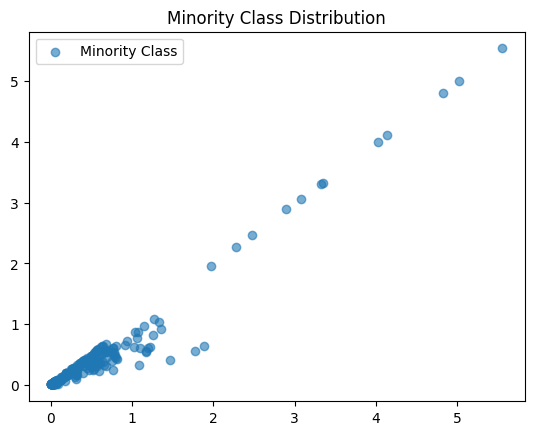

Original class distribution: Counter({0: 13708, 1: 307})
Resampled class distribution: Counter({0: 13708, 1: 13708})


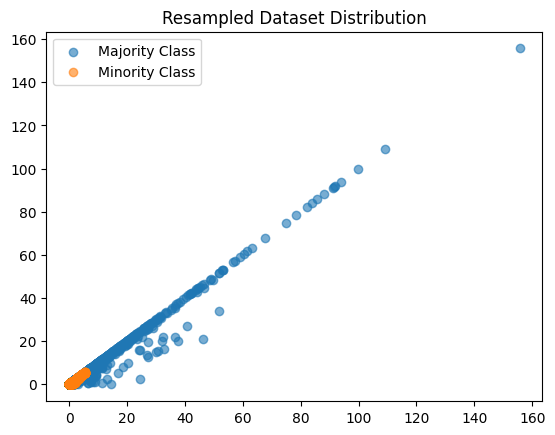

Time taken for svmsmote_resampling: 0.02 mins
 Total time taken for SVMSMOTE on MICE dataset: 0.02 mins
   Liquidity_and_Coverage_Ratios_PC1  Liquidity_and_Coverage_Ratios_PC2  \
0                           0.919373                           0.480067   
1                           1.422786                           0.403803   
2                           0.677826                           0.566012   

   Leverage_Ratios_PC1  Leverage_Ratios_PC2  Activity_Ratios_PC1  \
0            -0.697282            -0.012226            -1.010372   
1            -0.748927            -0.011086            -1.001474   
2            -0.730805            -0.009766            -0.997966   

   Activity_Ratios_PC2  Profitability_Ratios_PC1  Profitability_Ratios_PC2  \
0             0.019265                 -0.006831                 -0.009582   
1             0.018446                 -0.009090                 -0.008109   
2             0.018159                 -0.007141                 -0.008093   

   Cost_a

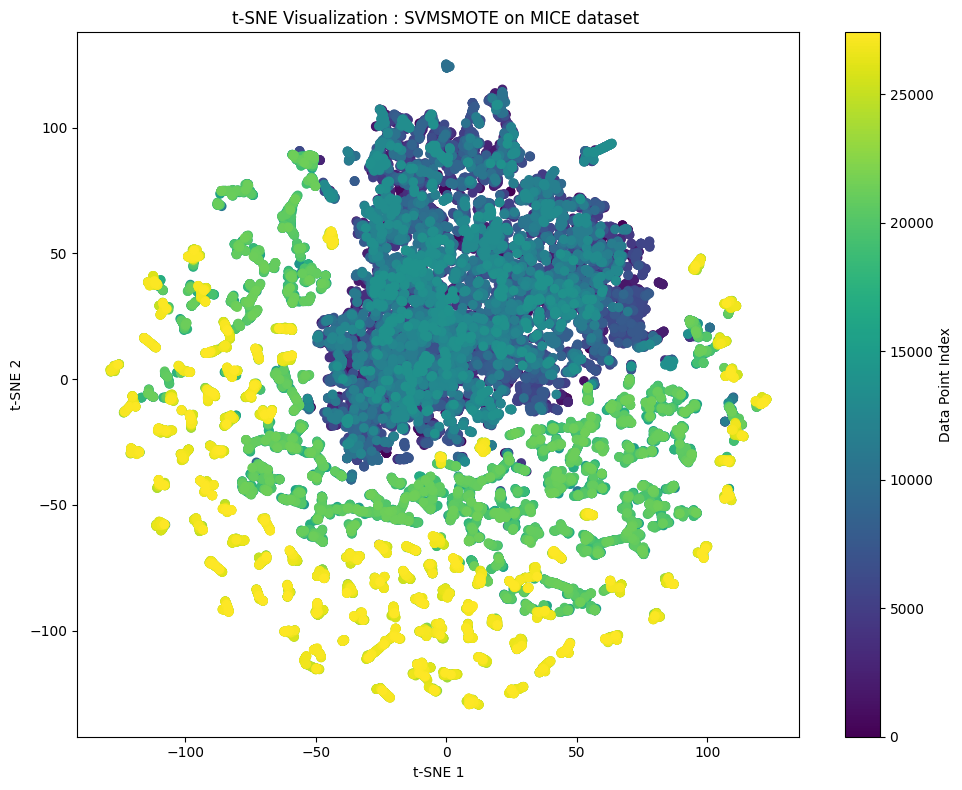

Comprehensive analysis on MICE processed dataset with SVM SMOTE:
Basic Statistics:
       Liquidity_and_Coverage_Ratios_PC1  Liquidity_and_Coverage_Ratios_PC2  \
count                       2.741600e+04                       2.741600e+04   
mean                        3.317387e-17                       8.293466e-18   
std                         1.694196e+00                       1.007624e+00   
min                        -8.514446e+00                      -5.494902e+01   
25%                        -5.609203e-01                      -1.685457e-01   
50%                        -3.082484e-01                       2.026111e-01   
75%                         8.730485e-02                       3.407777e-01   
max                         1.054319e+02                       2.889906e+01   

       Leverage_Ratios_PC1  Leverage_Ratios_PC2  Activity_Ratios_PC1  \
count         2.741600e+04         2.741600e+04         2.741600e+04   
mean         -1.658693e-17         1.457836e-19         1.244

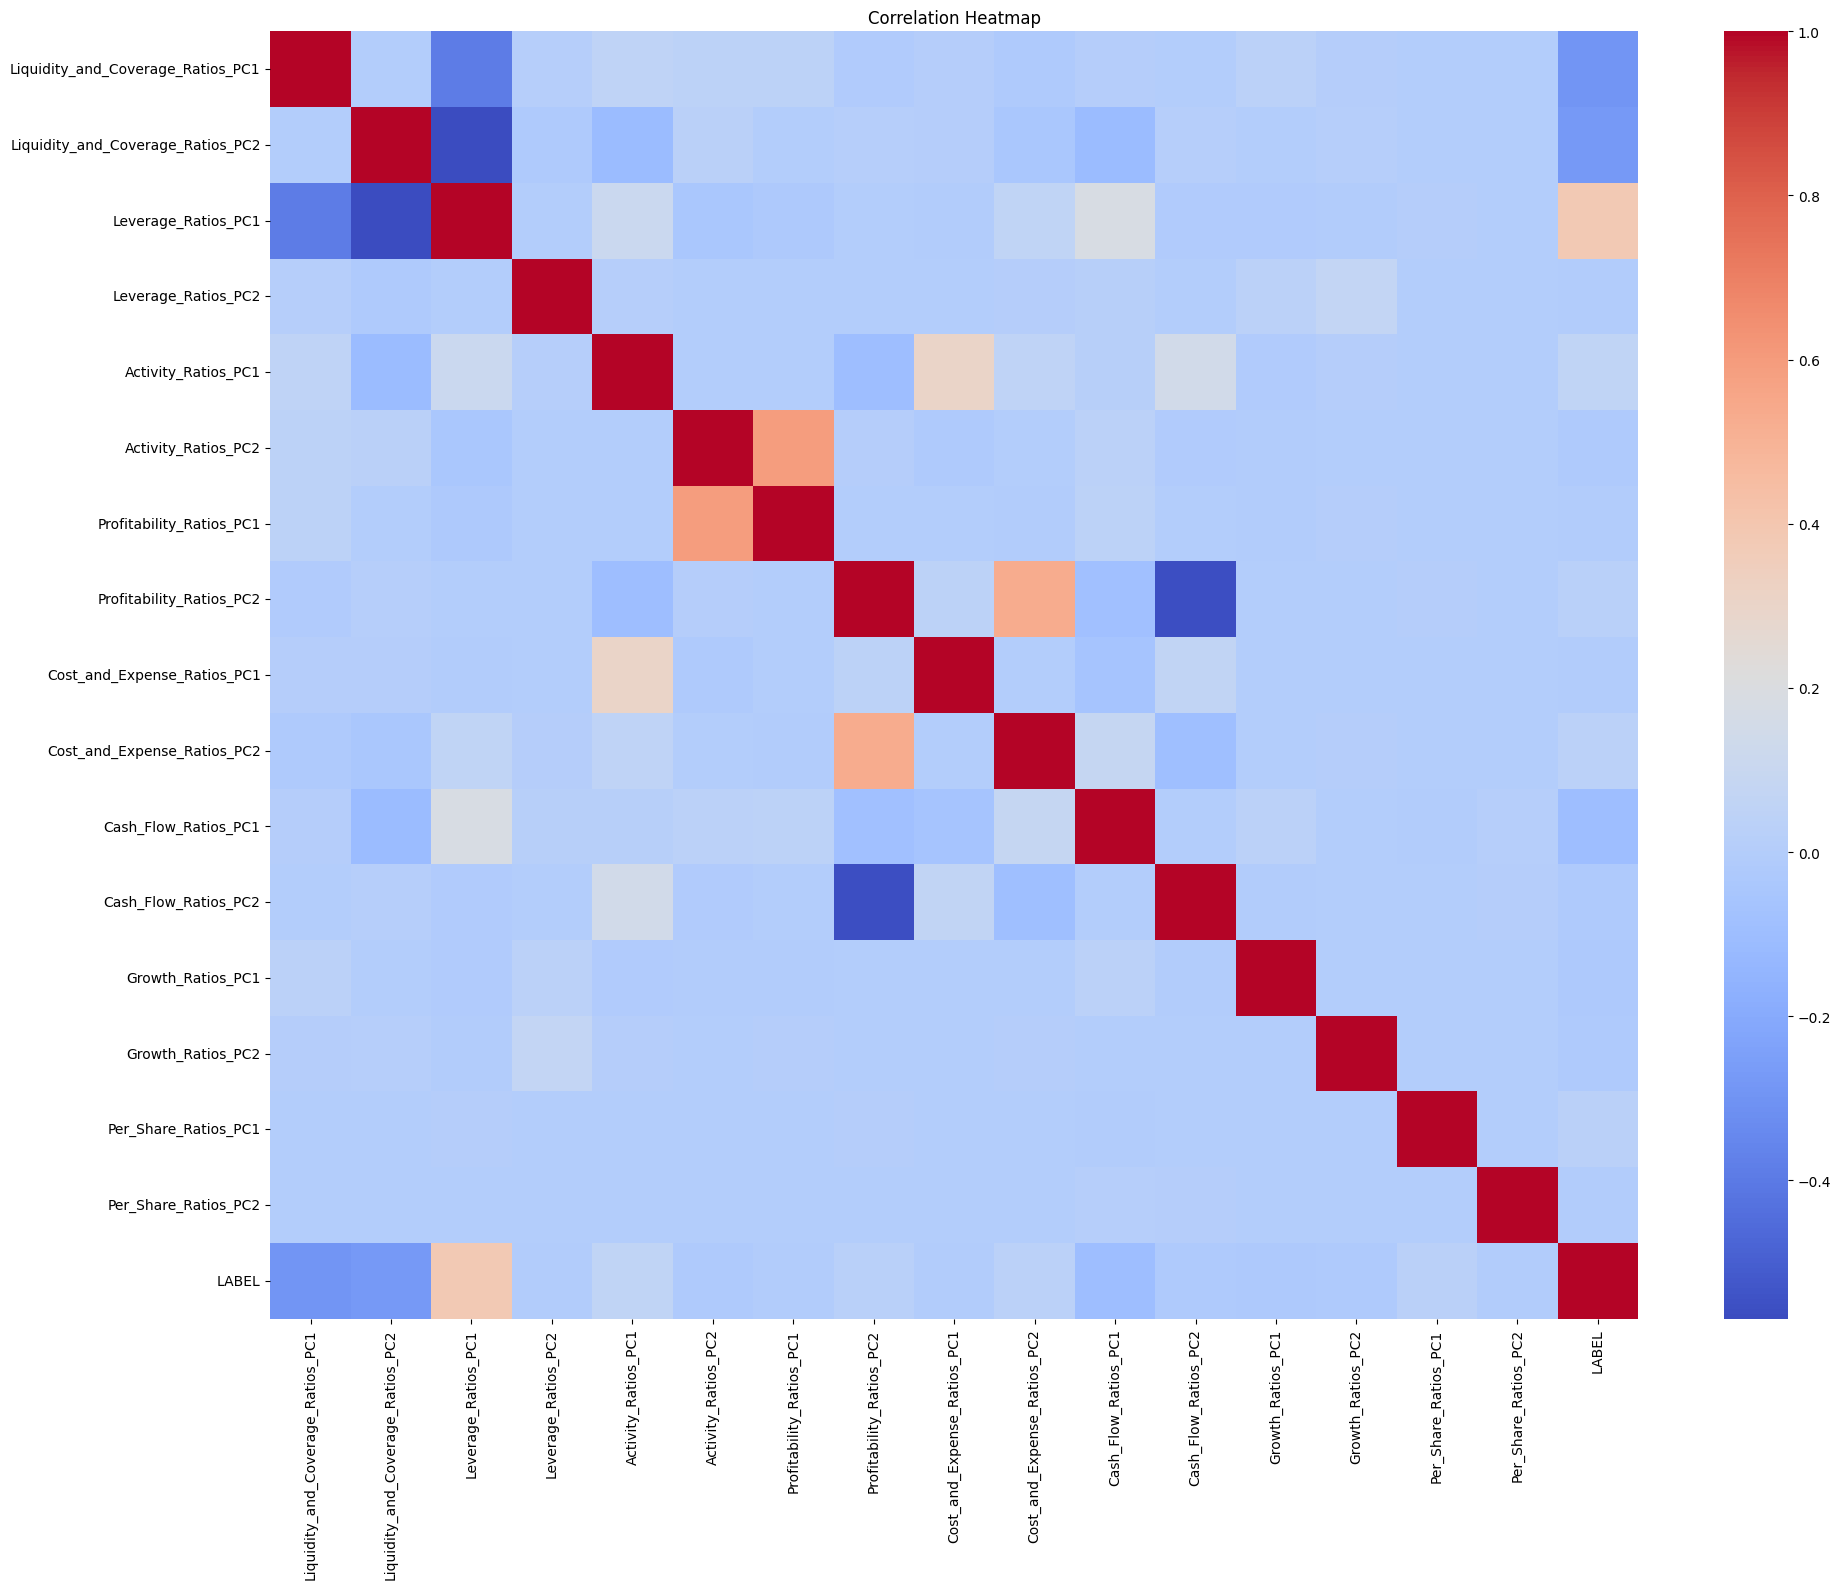


Highly correlated feature pairs:

Number of potential outliers (Isolation Forest): 2742
Number of potential outliers (Z-score > 3): 1998

Skewness of features:
Liquidity_and_Coverage_Ratios_PC1     17.409966
Liquidity_and_Coverage_Ratios_PC2    -15.511488
Leverage_Ratios_PC1                    8.235355
Leverage_Ratios_PC2                   61.355247
Activity_Ratios_PC1                   14.335748
Activity_Ratios_PC2                   89.617774
Profitability_Ratios_PC1             158.046117
Profitability_Ratios_PC2             -20.101827
Cost_and_Expense_Ratios_PC1          158.646649
Cost_and_Expense_Ratios_PC2           37.963408
Cash_Flow_Ratios_PC1                  14.435312
Cash_Flow_Ratios_PC2                  54.988452
Growth_Ratios_PC1                     63.683616
Growth_Ratios_PC2                     86.545741
Per_Share_Ratios_PC1                 -53.337727
Per_Share_Ratios_PC2                  11.551956
LABEL                                  0.000000
dtype: float64

Kurtosi

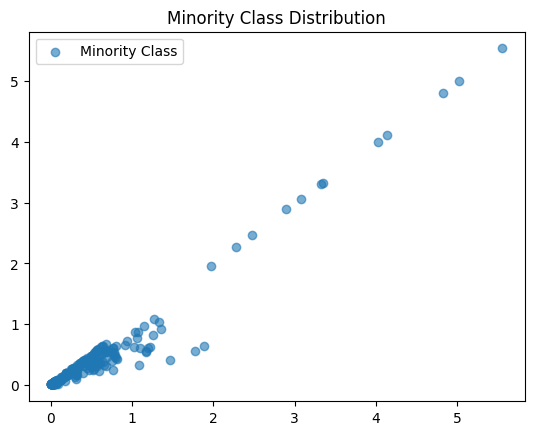

Original class distribution: Counter({0: 13708, 1: 307})
Resampled class distribution: Counter({0: 13708, 1: 13708})


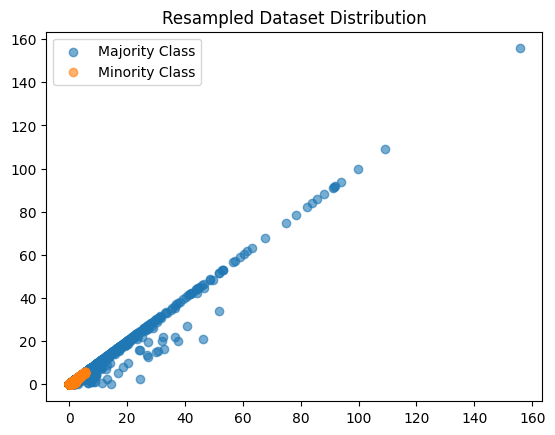

Time taken for svmsmote_resampling: 0.02 mins
 Total time taken for SVMSMOTE on Autoencoder dataset: 0.02 mins
   Liquidity_and_Coverage_Ratios_PC1  Liquidity_and_Coverage_Ratios_PC2  \
0                            0.92155                           0.476440   
1                            1.42421                           0.399778   
2                            0.68073                           0.559599   

   Leverage_Ratios_PC1  Leverage_Ratios_PC2  Activity_Ratios_PC1  \
0            -0.695837             0.014832            -0.665850   
1            -0.747575             0.014789            -0.661153   
2            -0.729419             0.012681            -0.658652   

   Activity_Ratios_PC2  Profitability_Ratios_PC1  Profitability_Ratios_PC2  \
0             0.239921                 -0.007062                 -0.011019   
1             0.232502                 -0.009320                 -0.009655   
2             0.231678                 -0.007372                 -0.009640   

  

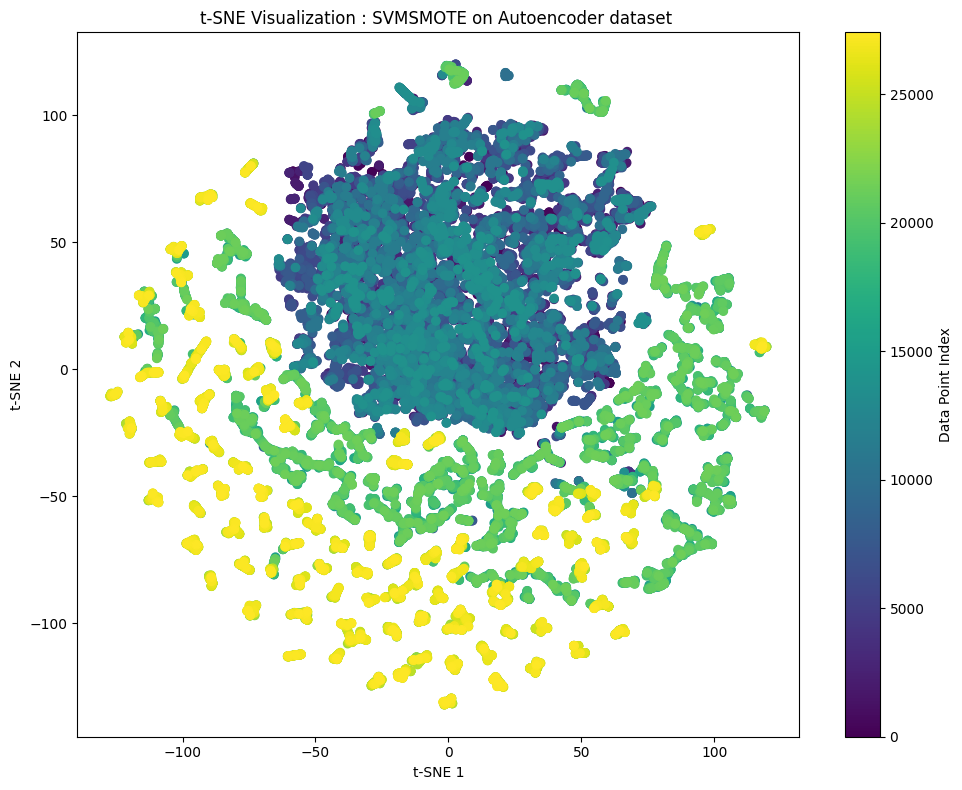

Comprehensive analysis on Autoencoder processed dataset with SVM SMOTE:
Basic Statistics:
       Liquidity_and_Coverage_Ratios_PC1  Liquidity_and_Coverage_Ratios_PC2  \
count                       2.741600e+04                       27416.000000   
mean                       -6.634773e-17                           0.000000   
std                         1.695452e+00                           1.006965   
min                        -8.534704e+00                         -54.511488   
25%                        -5.622814e-01                          -0.164424   
50%                        -3.061193e-01                           0.202258   
75%                         8.935833e-02                           0.341122   
max                         1.054298e+02                          32.280435   

       Leverage_Ratios_PC1  Leverage_Ratios_PC2  Activity_Ratios_PC1  \
count         27416.000000         2.741600e+04         2.741600e+04   
mean              0.000000        -1.069080e-18       

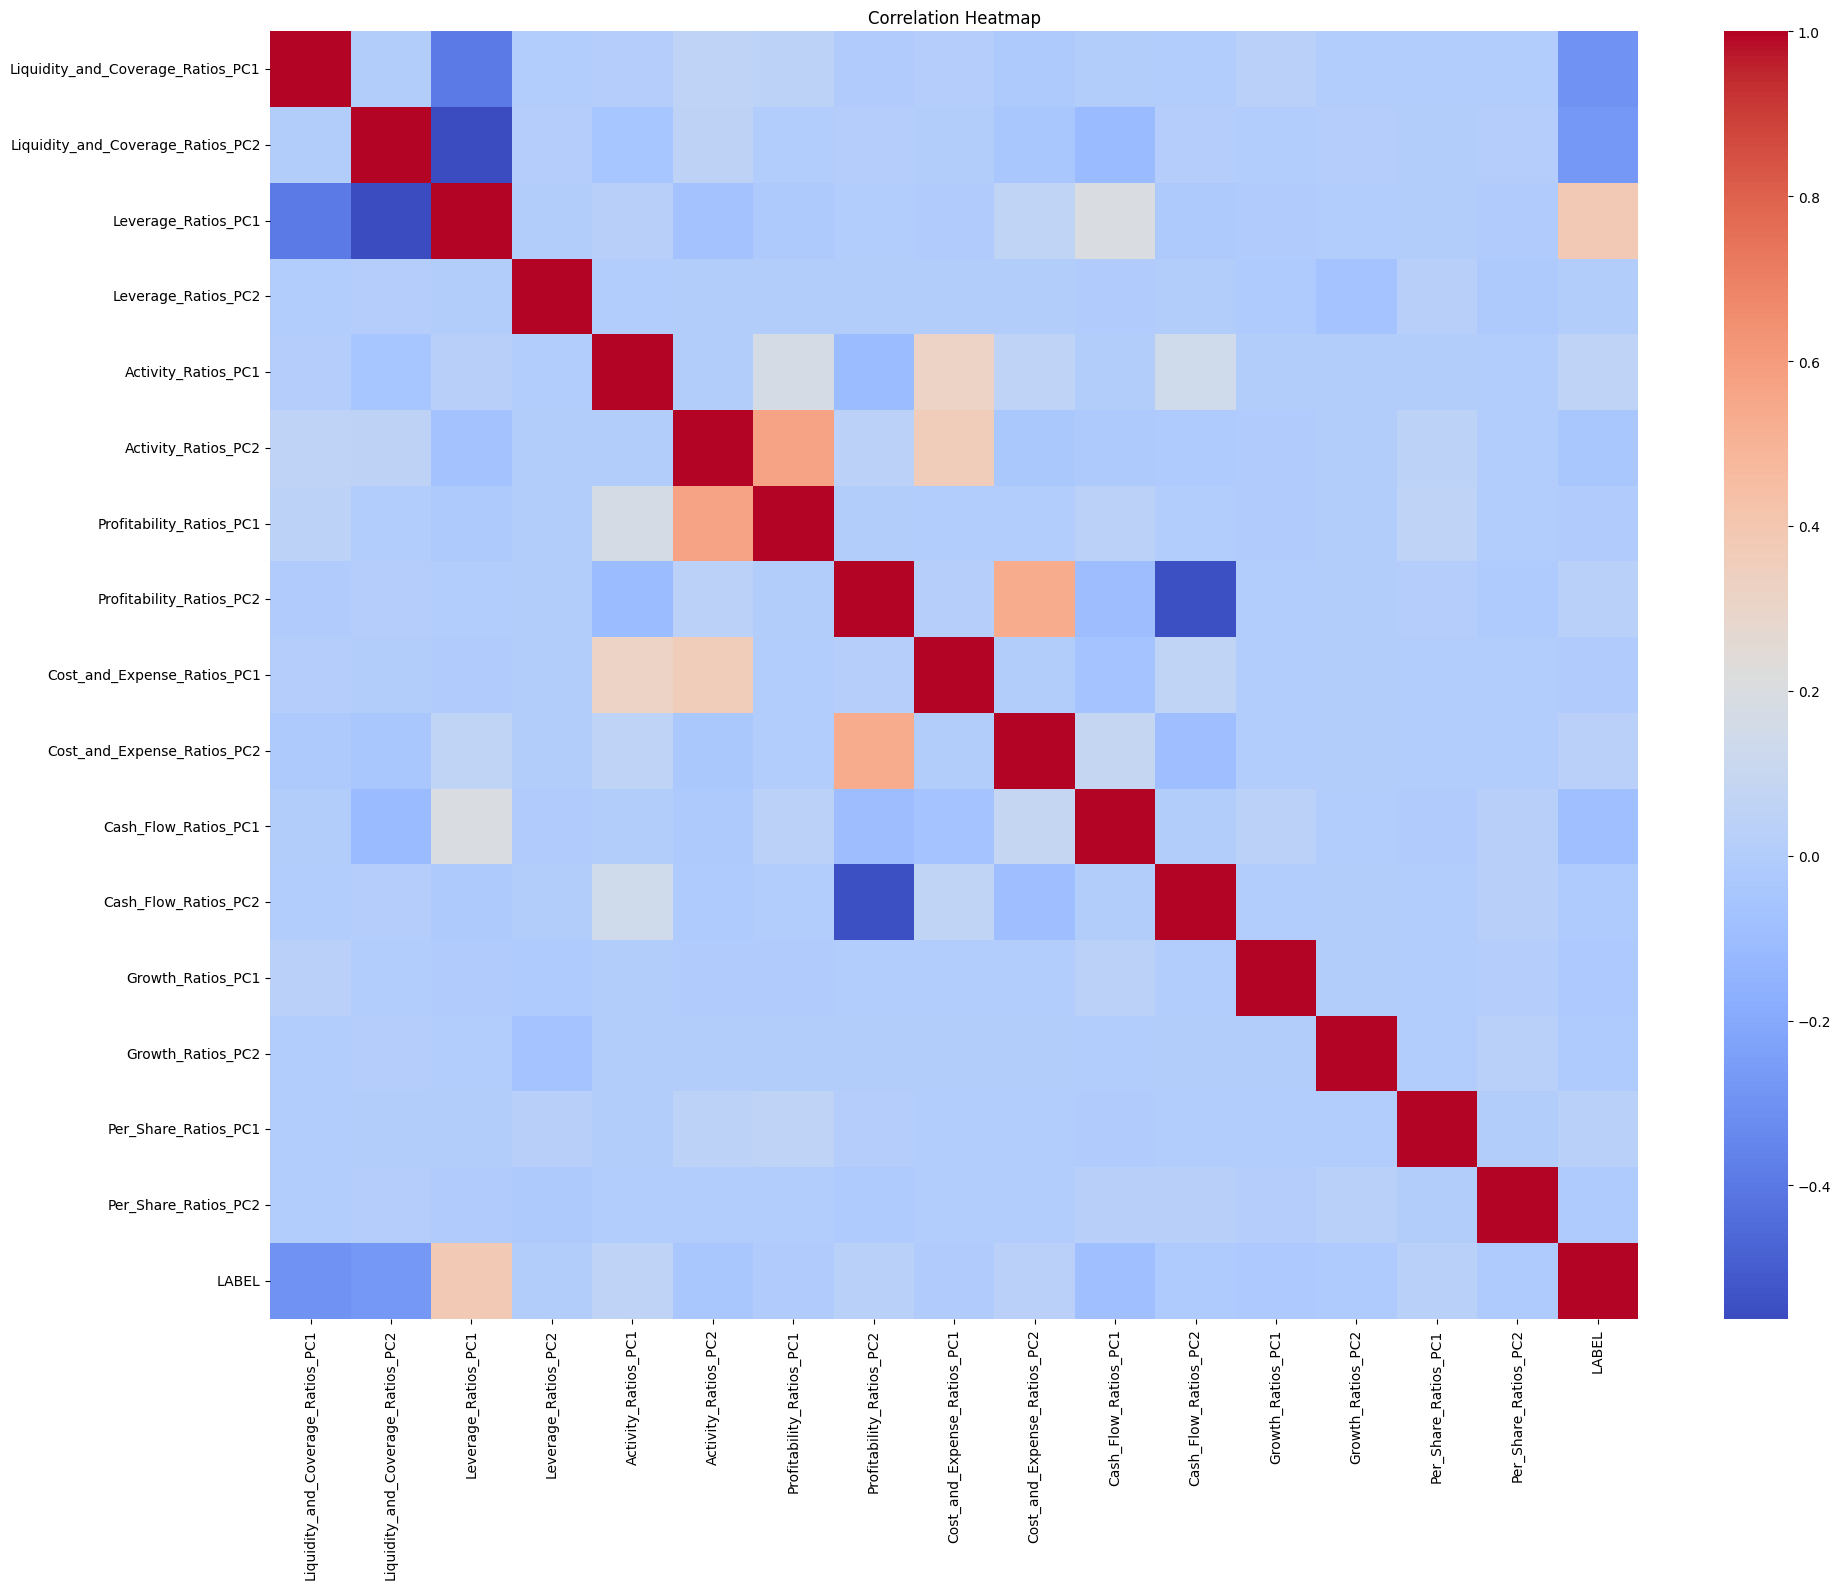


Highly correlated feature pairs:

Number of potential outliers (Isolation Forest): 2742
Number of potential outliers (Z-score > 3): 2014

Skewness of features:
Liquidity_and_Coverage_Ratios_PC1     17.350924
Liquidity_and_Coverage_Ratios_PC2    -14.875138
Leverage_Ratios_PC1                    8.017096
Leverage_Ratios_PC2                  -61.606183
Activity_Ratios_PC1                    9.784341
Activity_Ratios_PC2                   69.622069
Profitability_Ratios_PC1             158.045885
Profitability_Ratios_PC2             -22.686276
Cost_and_Expense_Ratios_PC1          159.339549
Cost_and_Expense_Ratios_PC2           35.689426
Cash_Flow_Ratios_PC1                  13.974769
Cash_Flow_Ratios_PC2                  51.104814
Growth_Ratios_PC1                     62.763111
Growth_Ratios_PC2                     83.674850
Per_Share_Ratios_PC1                 -52.884292
Per_Share_Ratios_PC2                  11.511030
LABEL                                  0.000000
dtype: float64

Kurtosi

In [13]:
main(df)